# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os 

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_tfidf = "../../../reports/reports_nohubs/analisis_tfidf/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

#agrego los nodos bert al df de disease attributes (aunque no tienen atributos)
nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values

#me quedo solo con las enfermedades que están en DD
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

In [4]:
tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [5]:
def load_sparse_dataframe(matrix_path,row_path,column_path):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    col = np.loadtxt(column_path, dtype="str")
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

In [6]:
# path = data_processed + "tfidf_nodos/"
# monogram_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
# bigram_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_3.txt")

In [ ]:
# pd.to_pickle(infomap_clusters,tfidf_reports+"infomap_analysis_checkpoint.pkl")
# pd.to_pickle(louvain_clusters,tfidf_reports+"louvain_analysis_checkpoint.pkl")

In [44]:
# analysis_infomap = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
# analysis_louvain = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

# path = data_processed + "tfidf_infomap/"
# path_louvain = data_processed + "tfidf_louvain/"
# monograms_infomap = load_sparse_dataframe(path + "matriz_tfidf_infomap_0.npz",path + "rows_tfidf_infomap_0.txt", path+"cols_tfidf_infomap_0.txt")
# monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")
# bigrams_infomap = load_sparse_dataframe(path + "matriz_tfidf_infomap_1.npz",path + "rows_tfidf_infomap_1.txt", path+"cols_tfidf_infomap_1.txt")
# trigrams_infomap = load_sparse_dataframe(path + "matriz_tfidf_infomap_2.npz",path + "rows_tfidf_infomap_2.txt", path+"cols_tfidf_infomap_2.txt")

# Exploro los datos

Ver cuantos nans tengo en total, cuantos por cada categoría.

Ver la longitud del texto de cada enfermedad (en tokens, no chars)

Ver de agregarle attr a los berts? Verificar si suelen tener tfidf bajo respecto a los demás


In [10]:
def quick_venn(item_list,set_names=None):
    plt.figure()
    venn_length = len(item_list)
    if venn_length == 2:
        s1 = set(item_list[0])
        s2 = set(item_list[1])
        v = venn2([s1,s2],set_names)
    if venn_length == 3:
        s1 = set(item_list[0])
        s2 = set(item_list[1])
        s3 = set(item_list[2])
        v = venn3([s1,s2,s3],set_names)

## Veo cobertura de datos

Nan counts para descripciones, según fuente:

False    9854
True     2514
Name: mondo_definition, dtype: int64
True     8417
False    3951
Name: orphanet_definition, dtype: int64
False    8325
True     4043
Name: umls_description, dtype: int64


Text(0.5, 1.0, 'De los nodos sin descripción, cuantos son Berts?')

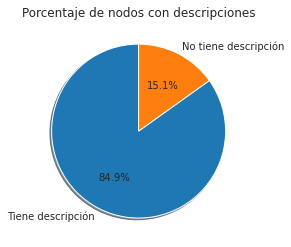

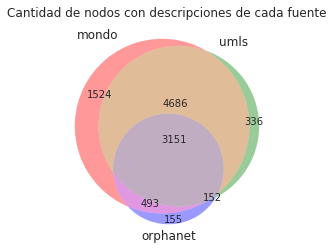

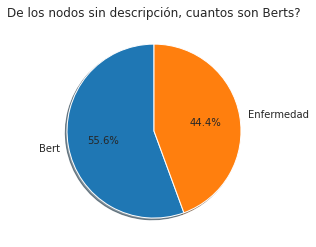

In [11]:
print("Nan counts para descripciones, según fuente:\n")
print(disease_attributes.mondo_definition.isna().value_counts())
print(disease_attributes.orphanet_definition.isna().value_counts())
print(disease_attributes.umls_description.isna().value_counts())

#all_cuis = set(disease_attributes.node_id.values)
mondo = set(disease_attributes[~disease_attributes.mondo_definition.isna()].node_id.values)
umls = set(disease_attributes[~disease_attributes.umls_description.isna()].node_id.values)
orphanet = set(disease_attributes[~disease_attributes.orphanet_definition.isna()].node_id.values)

no_desc = disease_attributes[(disease_attributes.mondo_definition.isna()) & (disease_attributes.umls_description.isna()) & (disease_attributes.orphanet_definition.isna())]
has_desc = disease_attributes[(~disease_attributes.mondo_definition.isna()) | (~disease_attributes.umls_description.isna()) | (~disease_attributes.orphanet_definition.isna())]

fig, ax = plt.subplots()
ax.pie([len(has_desc),len(no_desc)], labels=["Tiene descripción","No tiene descripción"], autopct='%1.1f%%',shadow=True, startangle=90)
# ax.axis('equal') 
ax.set_title("Porcentaje de nodos con descripciones")


quick_venn([mondo,umls,orphanet],["mondo","umls","orphanet"])
plt.title("Cantidad de nodos con descripciones de cada fuente")


fig, ax = plt.subplots()
ax.pie([len(no_desc[no_desc.node_source == "primekg"]),len(no_desc) - len(no_desc[no_desc.node_source == "primekg"])], labels=["Bert","Enfermedad"], autopct='%1.1f%%',shadow=True, startangle=90)
# ax.axis('equal') 
ax.set_title("De los nodos sin descripción, cuantos son Berts?")

Considerar agregar descripciones agrupadas a los grupos bert, esto va a "forzar" la similaridad pero creo que está bien que eso pase.

## Describo los datos

Algunas features están repetidas, esto es porque unas ontologías son más amplias que otras, entonces puede que distintos nodos tengan la misma definición en una ontología.

Las repeticiones deberían tender a agrupar juntos a esos nodos con tf-idf, pero está bien, por que **sabemos** que esos nodos **son** similares.

In [12]:
umls_repetido = len(disease_attributes[disease_attributes.umls_description.duplicated(keep=False)].dropna().sort_values(by="umls_description"))
mondo_repetido = len(disease_attributes[disease_attributes.mondo_definition.duplicated(keep=False)].dropna().sort_values(by="mondo_definition"))
orphanet_repetido = len(disease_attributes[disease_attributes.orphanet_definition.duplicated(keep=False)].dropna().sort_values(by="orphanet_definition"))

todas_repetidas = disease_attributes.dropna().duplicated(subset=["umls_description","mondo_definition","orphanet_definition"]).value_counts()[1]

display(pd.DataFrame.from_dict({"UMLS duplicada":umls_repetido, "MONDO duplicada":mondo_repetido,"Orphanet_repetido":orphanet_repetido,"Todas repetidas":todas_repetidas},orient="index").rename(columns={0:"Count"}))

,Count
UMLS duplicada,1217
MONDO duplicada,1102
Orphanet_repetido,1104
Todas repetidas,531


In [13]:
desc_cols = ["mondo_definition","umls_description","orphanet_definition"]

Las descripciones de UMLS tienden a ser más largas, esto es porque "colapsé" las definiciones diferentes que tenían en una sola. Voy a normalizar los vectores tf-idf para que esto no moleste.

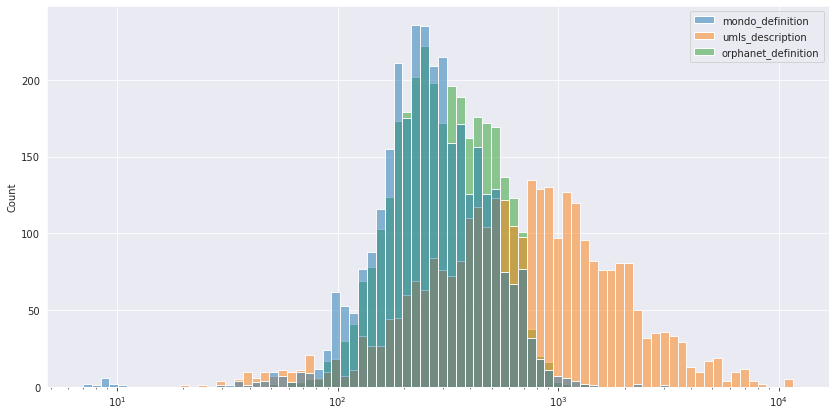

In [14]:
desc_lengths = disease_attributes[desc_cols].dropna().applymap(lambda x: len(x))

fig, ax = plt.subplots(figsize=(14,7))
plot = sns.histplot(data=desc_lengths, log_scale=True,ax=ax)

# Analisis TF-IDF

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
custom_stopwords = ["disease","syndrome","congenital","disorder","type","association","abnormality","hpo","probinson","pmid","24h","1st","2nd","3rd","i","ii","iii","iv","v","vi","vii","viii","ix"]
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stopwords)
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

## Preprocessing
Armado del corpus y el "documento" de cada cluster y preprocesado de texto. 

In [8]:
import regex as re

def remove_symbols(data):
    symbols = "!-.\"\'#$%&()*+/:;<=>?@[\]^_`{|}°,~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return data

def remove_numbers(text,any_number,whitespace):
    if any_number:
        text = re.sub(r'\d+', '', text)
    if whitespace:
        text = re.sub(r'\b(\d+)\b', '', text)
    return text

def more_regex_cleaning(text):
    patterns = [r'(\d+)hr',r'(\d+)th',r'(\d+)cm',r'(\d+)mm',r'(\d+)mmhg',r'\b[1-9][a-zA-Z]\b',r'\b[a-zA-Z][1-9]\b',r'(\d+)a',r'(\d+)b',r'(\d+)c']
    for pattern in patterns:
        text = re.sub(pattern, "", text)
    return text

lemmatizer = WordNetLemmatizer()
# def filter_plurals(lemmatizer, text):
#     words = text.split()
#     new_text = ""
#     for word in words :
#         lem = lemmatizer.lemmatize(word)
#         new_text += " " + lem
#     return new_text

def getWordNetPOS(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tagDict = {"J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV}
    return tagDict.get(tag, wordnet.NOUN)

def lemmatize_text(lemmatizer,text):
    words = text.split()
    new_text = ""
    tags = [getWordNetPOS(word) for word in words]
    for word,tag in zip(words,tags):
        lem = lemmatizer.lemmatize(word,pos=tag)
        new_text += " " + lem 
    return new_text

def filter_stopwords(text):
    new_text = ""
    words = text.split()
    for word in words:
        if word not in stop_words:
            new_text = new_text + " " + word
    return new_text

def preprocess(corpus,lemmatizer,lemma_filter,remove_stopwords=True,sub_numbers=False,regex_clean=True):
    corpus = np.char.lower(corpus)
    corpus = remove_symbols(corpus)
    if remove_stopwords:
        corpus = np.array([filter_stopwords(text) for text in corpus]).astype(str)
    if lemma_filter:
        corpus = np.array([lemmatize_text(lemmatizer,text) for text in corpus]).astype(str)
    if sub_numbers:
        corpus = np.array([remove_numbers(text,any_number=False,whitespace=True) for text in corpus]).astype(str)
    if regex_clean:
        corpus = np.array([more_regex_cleaning(text) for text in corpus]).astype(str)
    return corpus


def node_as_document(node_index,df,lemmatizer,lemma_filter=True,remove_stopwords=True,sub_numbers=True,join_titles=True):
    data = df.loc[df["node_index"] == node_index, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values.astype(str)
    data = np.delete(data,np.where(data[0] == "nan"))
    data = preprocess(data,lemmatizer,lemma_filter,remove_stopwords,sub_numbers)
    if join_titles:
        document = " ".join(data)
        document = document + " "
        document = document.replace(". ", " ")
    else:
        document = data
    return document


def node_name_as_document(node_index,df,lemmatizer,lemma_filter=True,remove_stopwords=True,sub_numbers=True,join_titles=True):
    data = df.loc[df["node_index"] == node_index, "node_name"].values.astype(str)
    data = preprocess(data,lemmatizer,lemma_filter,remove_stopwords,sub_numbers)
    if join_titles:
        document = " ".join(data)
        document = document + " "
        document = document.replace(". ", " ")
    else:
        document = data
    return document


def get_tfidf_df(vectorizer,corpus,ids,df=True):
    X = vectorizer.fit_transform(corpus)
    if df:
        #X = pd.DataFrame(X.toarray(), index=ids, columns=vectorizer.get_feature_names_out())
        X = pd.DataFrame.sparse.from_spmatrix(X, index=ids, columns=vectorizer.get_feature_names_out())
    return X

def tfidf_similarity(vectorizer,corpus,ids,df=True):
    scores = get_tfidf_df(vectorizer,corpus,ids,False)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

Ejemplo de preprocesado:

In [39]:
has_desc = disease_attributes[(~disease_attributes.mondo_definition.isna()) | (~disease_attributes.umls_description.isna()) | (~disease_attributes.orphanet_definition.isna())]
node_index = has_desc.sample(1).node_index.values[0]
node_info = disease_attributes.loc[disease_attributes.node_index == node_index, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values
print(f"Antes de preprocessing:\n {node_info}\n")
print("Después de preprocessing:")
node_as_document(node_index,disease_attributes,lemmatizer,sub_numbers=True)

Antes de preprocessing:
 [['Complex Endometrial Hyperplasia'
  'A hyperplasia characterized by excessive proliferation of endometrial cells, resulting in the formation of complex epithelial structures. Epithelial atypia may be present or absent.'
  'A hyperplasia characterized by excessive proliferation of endometrial cells, resulting in the formation of complex epithelial structures. Epithelial atypia may be present or absent. A benign form of endometrial hyperplasia with crowded endometrial glands and little stroma between the glands. Complex hyperplasia has low risk of progression to endometrial carcinoma.'
  nan]]

Después de preprocessing:


' complex endometrial hyperplasia  hyperplasia characterize excessive proliferation endometrial cell result formation complex epithelial structure epithelial atypia present absent  hyperplasia characterize excessive proliferation endometrial cell result formation complex epithelial structure epithelial atypia present absent benign form endometrial hyperplasia crowd endometrial gland little stroma gland complex hyperplasia low risk progression endometrial carcinoma '

In [9]:
processed_node_documents = {node_index:node_as_document(node_index,disease_attributes,lemmatizer) for node_index in disease_attributes.node_index.values}
processed_node_names = {node_index:node_name_as_document(node_index,disease_attributes,lemmatizer) for node_index in disease_attributes.node_index.values}

### Defino args de vectorizer unicos para usar en todo el código los mismos parámetros

In [10]:
args = {"min_df":3, "max_df":0.3}

## Calculo matrices TF-IDF (vocabulario extendido)


### Nodos

In [38]:
corpus = [processed_node_documents[node_index] for node_index in disease_attributes.node_index.values]
ids = disease_attributes.node_index.values

vectorizers = [TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=ngram_range, min_df=args["min_df"],max_df=args["max_df"])for ngram_range in [(1,1),(2,2),(3,3)]]

document_term_matrix = []
document_similarity_matrix = []

for i,vectorizer in enumerate(vectorizers):
    document_term_matrix.append(get_tfidf_df(vectorizer, corpus,ids))
    document_similarity_matrix.append(tfidf_similarity(vectorizer,corpus,ids))

In [39]:
path = graph_data+"tfidf_nodos/"

for i,mat in enumerate(document_term_matrix):
    cols = mat.columns.values
    rows = mat.index.values
    vals = mat.sparse.to_coo()
    sparse.save_npz(f"{path}matriz_nodos_tfidf_{i}.npz",vals)
    np.savetxt(f"{path}rows_tfidf_nodos_{i}.txt", rows)
    np.savetxt(f"{path}cols_tfidf_nodos_{i}.txt", cols,fmt="%s")

### Clusters

In [40]:
def cluster_as_document(cluster_id,df,cluster_algorithm,all_data=True):
    cluster_nodes = disease_attributes.loc[disease_attributes[cluster_algorithm] == cluster_id].node_index.values
    if all_data:
        cluster_corpus = [processed_node_documents[node_index] for node_index in cluster_nodes]
    else:
        cluster_corpus = [processed_node_names[node_index] for node_index in cluster_nodes]
        
    cluster_document = " ".join(cluster_corpus)
    return cluster_document

In [41]:
infomap_ids = infomap_clusters.comunidad.values
louvain_ids = louvain_clusters.comunidad.values

corpus_infomap = [cluster_as_document(cluster_id,disease_attributes,"comunidades_infomap") for cluster_id in infomap_ids]
corpus_louvain = [cluster_as_document(cluster_id,disease_attributes,"comunidades_louvain") for cluster_id in louvain_ids]

vectorizers = [TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=ngram_range, min_df=args["min_df"],max_df=args["max_df"])for ngram_range in [(1,1),(2,2),(3,3)]]

tfidf_infomap = []
tfidf_louvain = []

similarity_infomap = []
similarity_louvain = []

for i,vectorizer in enumerate(vectorizers):
    tfidf_infomap.append(get_tfidf_df(vectorizer, corpus_infomap,infomap_ids))
    tfidf_louvain.append(get_tfidf_df(vectorizer,corpus_louvain,louvain_ids))

    similarity_infomap.append(tfidf_similarity(vectorizer, corpus_infomap, infomap_ids))
    similarity_louvain.append(tfidf_similarity(vectorizer, corpus_louvain, louvain_ids))

tfidf_infomap_dense = [mat.sparse.to_dense() for mat in tfidf_infomap]
tfidf_louvain_dense = [mat.sparse.to_dense() for mat in tfidf_louvain]

In [49]:
path_infomap = graph_data + "tfidf_infomap/"
path_louvain = graph_data + "tfidf_louvain/"

for i,mat in enumerate(tfidf_infomap):
    cols = mat.columns.values
    rows = mat.index.values
    vals = mat.sparse.to_coo()
    sparse.save_npz(f"{path_infomap}matriz_tfidf_infomap_{i}.npz",vals)
    np.savetxt(f"{path_infomap}rows_tfidf_infomap_{i}.txt", rows)
    np.savetxt(f"{path_infomap}cols_tfidf_infomap_{i}.txt", cols,fmt="%s")

for i,mat in enumerate(tfidf_louvain):
    cols = mat.columns.values
    rows = mat.index.values
    vals = mat.sparse.to_coo()
    sparse.save_npz(f"{path_louvain}matriz_tfidf_louvain_{i}.npz",vals)
    np.savetxt(f"{path_louvain}rows_tfidf_louvain_{i}.txt", rows)
    np.savetxt(f"{path_louvain}cols_tfidf_louvain_{i}.txt", cols,fmt="%s")
    

# Repito los análisis del grafo anterior

### Ejemplos de clusters al azar

In [56]:
monogram_dtm = document_term_matrix[0]
ids = monogram_dtm.index.values
scores = monogram_dtm.sparse.to_coo()
similarity_matrix = cosine_similarity(scores,scores,False)
document_similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)

Similaridad media: 0.21


/tmp/ipykernel_22506/1259215033.py:6: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



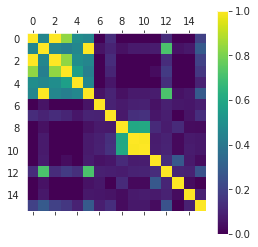

In [57]:
algoritmo = "comunidades_infomap"
cluster = infomap_clusters.sample(1).comunidad.values[0]
nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
plt.matshow(document_similarity_matrix.loc[nodos_cluster,nodos_cluster],vmin=0, vmax=1, cmap="viridis")
plt.grid(False)
plt.colorbar()

mean_sim = infomap_clusters.loc[infomap_clusters.comunidad == cluster, "mean_similarity_mono"].values[0]
print(f"Similaridad media: {mean_sim}")
#display(document_similarity_matrix.loc[nodos_cluster,nodos_cluster])

In [58]:
document_similarity_matrix.loc[nodos_cluster,nodos_cluster]

,1059,33665,31937,27201,27560,20937,21867,23988,23776,22352,30268,22875,20938,18572,22162,24391
1059,1.000000,0.460202,1.000000,0.834936,0.490306,0.460202,0.000000,0.125910,0.000000,0.000000,0.000000,0.000000,0.127282,0.000000,0.000000,0.193508
33665,0.460202,1.000000,0.460202,0.433002,0.463294,1.000000,0.051474,0.099458,0.045216,0.070480,0.071901,0.077288,0.718487,0.050193,0.063516,0.284560
31937,1.000000,0.460202,1.000000,0.834936,0.490306,0.460202,0.000000,0.125910,0.000000,0.000000,0.000000,0.000000,0.127282,0.000000,0.000000,0.193508
27201,0.834936,0.433002,0.834936,1.000000,0.565232,0.433002,0.000000,0.105127,0.000000,0.000000,0.000000,0.034650,0.168888,0.000000,0.000000,0.161567
27560,0.490306,0.463294,0.490306,0.565232,1.000000,0.463294,0.000000,0.061734,0.000000,0.000000,0.000000,0.000000,0.135947,0.000000,0.000000,0.094878
20937,0.460202,1.000000,0.460202,0.433002,0.463294,1.000000,0.051474,0.099458,0.045216,0.070480,0.071901,0.077288,0.718487,0.050193,0.063516,0.284560
21867,0.000000,0.051474,0.000000,0.000000,0.000000,0.051474,1.000000,0.097314,0.070841,0.089695,0.091504,0.049595,0.088435,0.065822,0.062161,0.083163
23988,0.125910,0.099458,0.125910,0.105127,0.061734,0.099458,0.097314,1.000000,0.067392,0.133788,0.142453,0.061629,0.082108,0.000000,0.051007,0.129294
23776,0.000000,0.045216,0.000000,0.000000,0.000000,0.045216,0.070841,0.067392,1.000000,0.600098,0.604998,0.120216,0.076105,0.119689,0.032341,0.028846
22352,0.000000,0.070480,0.000000,0.000000,0.000000,0.070480,0.089695,0.133788,0.600098,1.000000,0.995759,0.077969,0.096078,0.024509,0.073436,0.064729


In [59]:
graph_node_data[graph_node_data[algoritmo] == cluster]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
9445,1059,10880_8535_14217_12532_10996,"telangiectasia, hereditary hemorrhagic,",bert_group,primekg,630.0,13.0,0.0,0.0,5.0
9446,33665,C4551861,"Telangiectasia, Hereditary Hemorrhagic, Type 1",disease,disgenet,630.0,13.0,3.0,0.0,4.0
9447,31937,C3809710,"TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5",disease,disgenet,630.0,13.0,1.0,0.0,1.0
9448,27201,C1832529,HEREDITARY HEMORRHAGIC TELANGIECTASIA-RELATED ...,disease,disgenet,630.0,13.0,1.0,0.0,1.0
9449,27560,C1838163,OSLER-RENDU-WEBER SYNDROME 2,disease,disgenet,630.0,13.0,1.0,0.0,1.0
9450,20937,C0039445,Hereditary hemorrhagic telangiectasia,disease,disgenet,630.0,13.0,4.0,0.0,4.0
12257,21867,C0162819,"Skin Diseases, Vascular",disease,disgenet,630.0,13.0,1.0,0.0,26.0
18444,23988,C0345419,Cutis marmorata telangiectatica congenita,disease,disgenet,630.0,13.0,1.0,0.0,2.0
19181,23776,C0340803,Capillary malformation (disorder),disease,disgenet,630.0,13.0,2.0,0.0,7.0
24671,22352,C0235752,Port-Wine Stain,disease,disgenet,630.0,13.0,2.0,0.0,3.0


In [60]:
random_node = np.random.choice(nodos_cluster,1)[0]
most_similar = document_similarity_matrix[random_node].sort_values(ascending=False)[0:10]
graph_node_data.set_index("node_index").loc[most_similar.index.values]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
27201,C1832529,HEREDITARY HEMORRHAGIC TELANGIECTASIA-RELATED ...,disease,disgenet,630.0,13.0,1.0,0.0,1.0
31937,C3809710,"TELANGIECTASIA, HEREDITARY HEMORRHAGIC, TYPE 5",disease,disgenet,630.0,13.0,1.0,0.0,1.0
1059,10880_8535_14217_12532_10996,"telangiectasia, hereditary hemorrhagic,",bert_group,primekg,630.0,13.0,0.0,0.0,5.0
27560,C1838163,OSLER-RENDU-WEBER SYNDROME 2,disease,disgenet,630.0,13.0,1.0,0.0,1.0
27242,C1832942,JUVENILE POLYPOSIS/HEREDITARY HEMORRHAGIC TELA...,disease,disgenet,177.0,14.0,1.0,0.0,1.0
1570,11457_18266,ataxia - telangiectasia variant,bert_group,primekg,637.0,50.0,0.0,0.0,6.0
33665,C4551861,"Telangiectasia, Hereditary Hemorrhagic, Type 1",disease,disgenet,630.0,13.0,3.0,0.0,4.0
20937,C0039445,Hereditary hemorrhagic telangiectasia,disease,disgenet,630.0,13.0,4.0,0.0,4.0
31727,C3714844,"Pulmonary Hypertension, Primary, 1, With Hered...",disease,disgenet,487.0,22.0,7.0,0.0,1.0


## Entropía tfidf de clusters

In [6]:
def load_cluster_matrices(path_infomap:str,path_louvain:str):
    tfidf_infomap = []
    tfidf_louvain = []

    for i in range(3):
        mat_path = f"{path_infomap}matriz_tfidf_infomap_{i}.npz"
        row_path = f"{path_infomap}rows_tfidf_infomap_{i}.txt"
        col_path = f"{path_infomap}cols_tfidf_infomap_{i}.txt"
        
        tfidf_infomap.append(load_sparse_dataframe(mat_path,row_path,col_path))

    for i in range(3):
        mat_path = f"{path_louvain}matriz_tfidf_louvain_{i}.npz"
        row_path = f"{path_louvain}rows_tfidf_louvain_{i}.txt"
        col_path = f"{path_louvain}cols_tfidf_louvain_{i}.txt"
        
        tfidf_louvain.append(load_sparse_dataframe(mat_path,row_path,col_path))
    
    return tfidf_infomap, tfidf_louvain

In [7]:
path_infomap = graph_data + "tfidf_infomap/"
path_louvain = graph_data + "tfidf_louvain/"

tfidf_infomap, tfidf_louvain = load_cluster_matrices(path_infomap,path_louvain)

tfidf_infomap_dense = [mat.sparse.to_dense() for mat in tfidf_infomap]
tfidf_louvain_dense = [mat.sparse.to_dense() for mat in tfidf_louvain]

In [8]:
import scipy.stats
from scipy.stats import entropy
def get_entropy(series,max_normalized=True,normalize_l1=True):
    """Calcula la entropía para una columna de valores de pandas. 
    La extrae como un array y la normaliza para que la suma sea 1 y después calcula la entropía.
    La normalizo por la entropía máxima posible, que sería la distribución uniforme pi=1/(b-a) para valores entre b y a. 
    En este caso es simplemente 1/ el largo del array"""
    values = series.values
    if normalize_l1:
        arr = values/(np.sum(values))
    else:
        arr = values
    if max_normalized:
        max_entropy = entropy(np.ones(len(arr))/len(arr), base=2)
        S = round(entropy(arr, base=2)/max_entropy,2)
    else:
        S = round(entropy(arr, base=2))
    return S

ngrams=1:
S big cluster = 0.53, S small cluster = 0.61


ngrams=2:
S big cluster = 0.53, S small cluster = 0.56


ngrams=3:
S big cluster = 0.5, S small cluster = 0.5




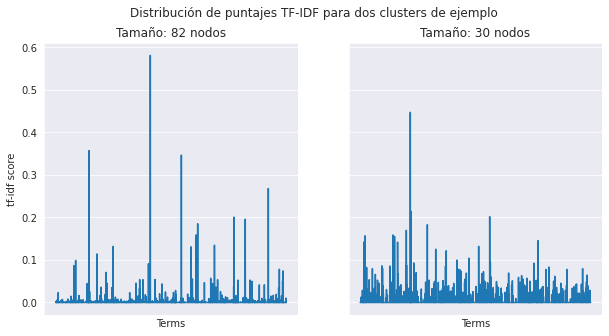

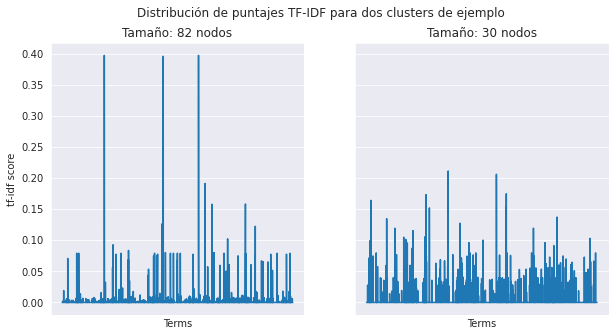

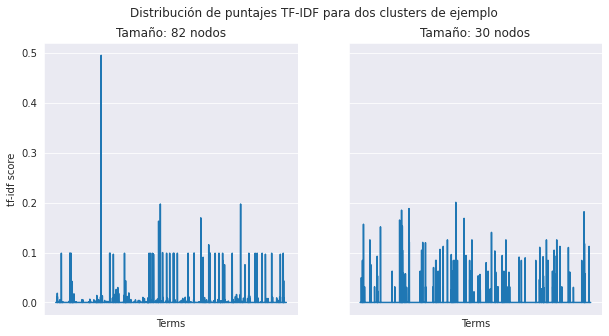

In [9]:
big_cluster = 382
small_cluster = 349

for n in range(3):
    fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
    fig.suptitle("Distribución de puntajes TF-IDF para dos clusters de ejemplo")

    ax[0].set_xticks([])
    ax[0].set_title(f"Tamaño: {tamaños_infomap.loc[big_cluster]} nodos")

    ax[1].set_xticks([])
    ax[1].set_title(f"Tamaño: {tamaños_infomap.loc[small_cluster]} nodos")

    tfidf_infomap_dense[n].loc[big_cluster].plot(ax=ax[0], xlabel='Terms', ylabel='tf-idf score')
    tfidf_infomap_dense[n].loc[small_cluster].plot(ax=ax[1], xlabel='Terms')

    ax[0].grid(True)
    ax[1].grid(True)

    print(f"ngrams={n+1}:\nS big cluster = {get_entropy(tfidf_infomap_dense[n].loc[big_cluster])}, S small cluster = {get_entropy(tfidf_infomap_dense[n].loc[small_cluster])}\n\n")

In [35]:
tfidf_infomap_dense[0].loc[big_cluster].value_counts()

0.000000    7348
0.001045       7
0.000981       6
0.002090       5
0.000936       5
            ... 
0.000522       1
0.004510       1
0.000596       1
0.007957       1
0.010215       1
Name: 382.0, Length: 446, dtype: int64

In [32]:
arr = tfidf_infomap_dense[0].loc[big_cluster].values
arr_norm = arr/np.sum(arr)
arr_max = np.max(arr_norm)
arr_mean = np.mean(arr_norm)
(arr_max/arr_mean)/len(arr)

0.08584533964849163

In [29]:
arr = tfidf_infomap_dense[0].loc[small_cluster].values
arr_max = np.max(arr)
arr_mean = np.mean(arr)
arr_max/arr_mean

276.36789127331826

In [16]:
entropias_infomap = {}
for i,tfidf_matrix in enumerate(tfidf_infomap_dense):
    entropias = [get_entropy(tfidf_matrix.loc[cluster]) for cluster in infomap_clusters.comunidad.values]
    entropias_infomap[i] = np.array(entropias)


entropias_louvain = {}

for i,tfidf_matrix in enumerate(tfidf_louvain_dense):
    entropias = [get_entropy(tfidf_matrix.loc[cluster]) for cluster in louvain_clusters.comunidad.values]
    entropias_louvain[i] = np.array(entropias)

/tmp/ipykernel_5033/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


In [18]:
infomap_ids = infomap_clusters.comunidad.values
louvain_ids = louvain_clusters.comunidad.values

series_infomap = []

for i,S in entropias_infomap.items():
    i_series = pd.Series({cluster:S for (cluster,S) in zip(infomap_ids, S)}, name=f"entropia_{i+1}")
    series_infomap.append(i_series)

entropias_infomap_df = pd.DataFrame(series_infomap).T


series_louvain = []

for i,S in entropias_louvain.items():
    i_series = pd.Series({cluster:S for (cluster,S) in zip(louvain_ids, S)}, name=f"entropia_{i+1}")
    series_louvain.append(i_series)

entropias_louvain_df = pd.DataFrame(series_louvain).T

Agrego las entropías al dataframe

In [19]:
infomap_clusters = pd.merge(infomap_clusters, entropias_infomap_df, left_on="comunidad", right_index=True, how="left")
louvain_clusters = pd.merge(louvain_clusters,entropias_louvain_df, left_on="comunidad", right_index=True, how="left")

In [24]:
# infomap_clusters.to_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
# louvain_clusters.to_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

### Calculo entropía de clusters random

In [12]:
def cluster_as_document_random(cluster_id,df,cluster_algorithm):
    cluster_nodes = df.loc[df[cluster_algorithm] == cluster_id].node_index.values
    cluster_corpus = [processed_node_documents[node_index] for node_index in cluster_nodes]
    cluster_document = " ".join(cluster_corpus)
    return cluster_document

In [13]:
disease_attributes_shuffle_columns = disease_attributes[["comunidades_infomap","comunidades_louvain"]]
disease_attributes_shuffle_values = disease_attributes[["node_index","node_id","node_name","mondo_name","mondo_definition","umls_description","orphanet_definition"]]

Iter 0 of 100
Iter 1 of 100
Iter 2 of 100
Iter 3 of 100
Iter 4 of 100
Iter 5 of 100


/tmp/ipykernel_29469/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


Iter 6 of 100
Iter 7 of 100
Iter 8 of 100
Iter 9 of 100
Iter 10 of 100
Iter 11 of 100
Iter 12 of 100


/tmp/ipykernel_29469/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


Iter 13 of 100
Iter 14 of 100
Iter 15 of 100
Iter 16 of 100
Iter 17 of 100
Iter 18 of 100
Iter 19 of 100
Iter 20 of 100
Iter 21 of 100
Iter 22 of 100
Iter 23 of 100
Iter 24 of 100
Iter 25 of 100
Iter 26 of 100
Iter 27 of 100
Iter 28 of 100
Iter 29 of 100
Iter 30 of 100
Iter 31 of 100
Iter 32 of 100
Iter 33 of 100
Iter 34 of 100
Iter 35 of 100


/tmp/ipykernel_29469/336944128.py:10: RuntimeWarning: invalid value encountered in divide
  arr = values/(np.sum(values))


Iter 36 of 100
Iter 37 of 100
Iter 38 of 100
Iter 39 of 100
Iter 40 of 100
Iter 41 of 100
Iter 42 of 100
Iter 43 of 100
Iter 44 of 100
Iter 45 of 100
Iter 46 of 100
Iter 47 of 100
Iter 48 of 100
Iter 49 of 100
Iter 50 of 100
Iter 51 of 100
Iter 52 of 100
Iter 53 of 100
Iter 54 of 100
Iter 55 of 100
Iter 56 of 100
Iter 57 of 100
Iter 58 of 100
Iter 59 of 100
Iter 60 of 100
Iter 61 of 100
Iter 62 of 100
Iter 63 of 100
Iter 64 of 100
Iter 65 of 100
Iter 66 of 100
Iter 67 of 100
Iter 68 of 100
Iter 69 of 100
Iter 70 of 100
Iter 71 of 100
Iter 72 of 100
Iter 73 of 100
Iter 74 of 100
Iter 75 of 100
Iter 76 of 100
Iter 77 of 100
Iter 78 of 100
Iter 79 of 100
Iter 80 of 100
Iter 81 of 100
Iter 82 of 100
Iter 83 of 100
Iter 84 of 100
Iter 85 of 100
Iter 86 of 100
Iter 87 of 100
Iter 88 of 100
Iter 89 of 100
Iter 90 of 100
Iter 91 of 100
Iter 92 of 100
Iter 93 of 100
Iter 94 of 100
Iter 95 of 100
Iter 96 of 100
Iter 97 of 100
Iter 98 of 100
Iter 99 of 100


/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


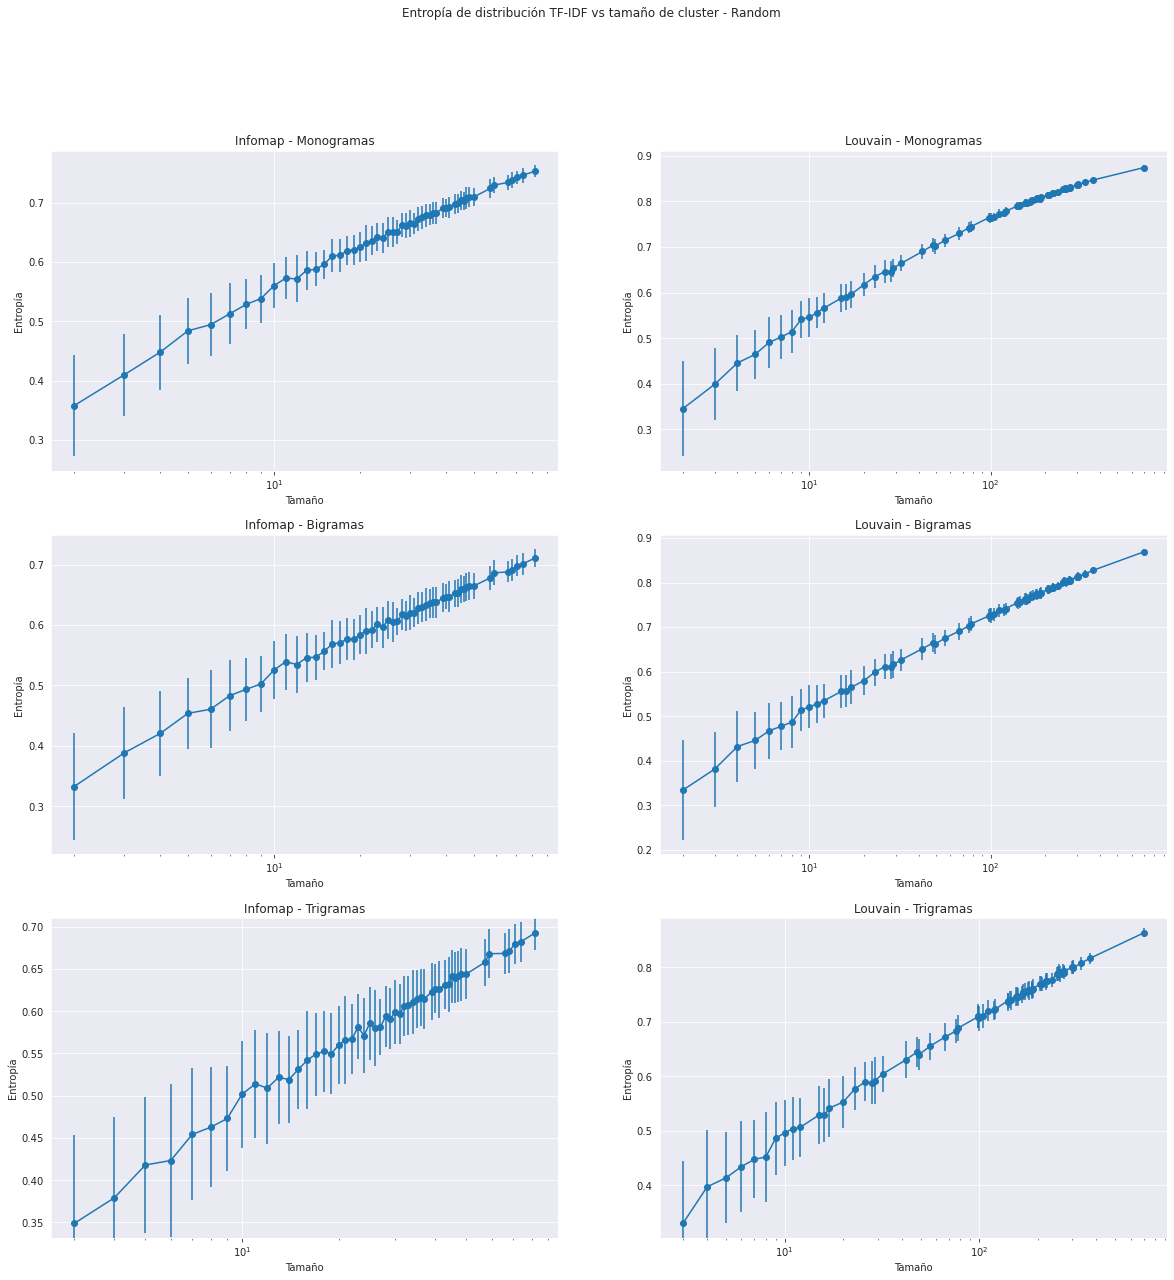

In [14]:
ids_random_infomap = infomap_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_infomap = infomap_clusters.set_index("comunidad").loc[ids_random_infomap,"tamaño"].values

ids_random_louvain = louvain_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_louvain = louvain_clusters.set_index("comunidad").loc[ids_random_louvain,"tamaño"].values

infomap_ids = infomap_clusters.comunidad.values
louvain_ids = louvain_clusters.comunidad.values

args = {"min_df":3, "max_df":0.3}
vectorizer_mono = TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=(1,1), min_df=args["min_df"],max_df=args["max_df"])
vectorizer_bi = TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=(2,2), min_df=args["min_df"],max_df=args["max_df"])
vectorizer_tri = TfidfVectorizer(tokenizer = None , stop_words=stop_words, ngram_range=(3,3), min_df=args["min_df"],max_df=args["max_df"])

iters = 100

results_infomap_mono = []
results_louvain_mono = []

results_infomap_bi = []
results_louvain_bi = []

results_infomap_tri = []
results_louvain_tri = []

for _ in range(iters):
    shuffled_df = pd.merge(disease_attributes_shuffle_values.sample(frac=1).reset_index(drop=True),disease_attributes_shuffle_columns, left_index=True, right_index=True)

    corpus_infomap_random = [cluster_as_document_random(cluster_id,shuffled_df,"comunidades_infomap") for cluster_id in infomap_ids]
    corpus_louvain_random = [cluster_as_document_random(cluster_id,shuffled_df,"comunidades_louvain") for cluster_id in louvain_ids]

    tfidf_infomap_random_mono = get_tfidf_df(vectorizer_mono, corpus_infomap_random,infomap_ids).sparse.to_dense()
    tfidf_louvain_random_mono = get_tfidf_df(vectorizer_mono,corpus_louvain_random,louvain_ids).sparse.to_dense()

    tfidf_infomap_random_bi = get_tfidf_df(vectorizer_bi, corpus_infomap_random,infomap_ids).sparse.to_dense()
    tfidf_louvain_random_bi = get_tfidf_df(vectorizer_bi,corpus_louvain_random,louvain_ids).sparse.to_dense()

    tfidf_infomap_random_tri = get_tfidf_df(vectorizer_tri, corpus_infomap_random,infomap_ids).sparse.to_dense()
    tfidf_louvain_random_tri = get_tfidf_df(vectorizer_tri, corpus_louvain_random,louvain_ids).sparse.to_dense()

    entropias_infomap_random_mono = [get_entropy(tfidf_infomap_random_mono.loc[cluster], normalize_l1 = True) for cluster in ids_random_infomap]
    entropias_louvain_random_mono = [get_entropy(tfidf_louvain_random_mono.loc[cluster], normalize_l1 = True) for cluster in ids_random_louvain]

    entropias_infomap_random_bi = [get_entropy(tfidf_infomap_random_bi.loc[cluster], normalize_l1 = True) for cluster in ids_random_infomap]
    entropias_louvain_random_bi = [get_entropy(tfidf_louvain_random_bi.loc[cluster], normalize_l1 = True) for cluster in ids_random_louvain]

    entropias_infomap_random_tri = [get_entropy(tfidf_infomap_random_tri.loc[cluster], normalize_l1 = True) for cluster in ids_random_infomap]
    entropias_louvain_random_tri = [get_entropy(tfidf_louvain_random_tri.loc[cluster], normalize_l1 = True) for cluster in ids_random_louvain]

    results_infomap_mono.append(entropias_infomap_random_mono)
    results_louvain_mono.append(entropias_louvain_random_mono)

    results_infomap_bi.append(entropias_infomap_random_bi)
    results_louvain_bi.append(entropias_louvain_random_bi)

    results_infomap_tri.append(entropias_infomap_random_tri)
    results_louvain_tri.append(entropias_louvain_random_tri)

    print(f"Iter {_} of {iters}")

means_infomap_mono = [np.mean(arr) for arr in np.array(results_infomap_mono).T]
stds_infomap_mono = [np.std(arr) for arr in np.array(results_infomap_mono).T] 

means_louvain_mono = [np.mean(arr) for arr in np.array(results_louvain_mono).T]
stds_louvain_mono = [np.std(arr) for arr in np.array(results_louvain_mono).T]


means_infomap_bi = [np.mean(arr) for arr in np.array(results_infomap_bi).T]
stds_infomap_bi = [np.std(arr) for arr in np.array(results_infomap_bi).T] 

means_louvain_bi = [np.mean(arr) for arr in np.array(results_louvain_bi).T]
stds_louvain_bi = [np.std(arr) for arr in np.array(results_louvain_bi).T]


means_infomap_tri = [np.mean(arr) for arr in np.array(results_infomap_tri).T]
stds_infomap_tri = [np.std(arr) for arr in np.array(results_infomap_tri).T] 

means_louvain_tri = [np.mean(arr) for arr in np.array(results_louvain_tri).T]
stds_louvain_tri = [np.std(arr) for arr in np.array(results_louvain_tri).T]


fig, ax = plt.subplots(3,2, figsize=(20,20))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster - Random")
ax[0][0].scatter(tamaños_random_infomap,means_infomap_mono)
ax[0][0].errorbar(tamaños_random_infomap,means_infomap_mono,yerr=stds_infomap_mono)
ax[0][0].set_title("Infomap - Monogramas")
ax[0][0].grid(True)
ax[0][0].set_xlabel("Tamaño")
ax[0][0].set_ylabel("Entropía")
ax[0][0].set_xscale("log")

ax[0][1].scatter(tamaños_random_louvain,means_louvain_mono)
ax[0][1].errorbar(tamaños_random_louvain,means_louvain_mono,yerr=stds_louvain_mono)
ax[0][1].set_xscale("log")
ax[0][1].set_title("Louvain - Monogramas")
ax[0][1].grid(True)
ax[0][1].set_xlabel("Tamaño")
ax[0][1].set_ylabel("Entropía")

ax[1][0].scatter(tamaños_random_infomap,means_infomap_bi)
ax[1][0].errorbar(tamaños_random_infomap,means_infomap_bi,yerr=stds_infomap_bi)
ax[1][0].set_title("Infomap - Bigramas")
ax[1][0].grid(True)
ax[1][0].set_xlabel("Tamaño")
ax[1][0].set_ylabel("Entropía")
ax[1][0].set_xscale("log")

ax[1][1].scatter(tamaños_random_louvain,means_louvain_bi)
ax[1][1].errorbar(tamaños_random_louvain,means_louvain_bi,yerr=stds_louvain_bi)
ax[1][1].set_xscale("log")
ax[1][1].set_title("Louvain - Bigramas")
ax[1][1].grid(True)
ax[1][1].set_xlabel("Tamaño")
ax[1][1].set_ylabel("Entropía")

ax[2][0].scatter(tamaños_random_infomap,means_infomap_tri)
ax[2][0].errorbar(tamaños_random_infomap,means_infomap_tri,yerr=stds_infomap_tri)
ax[2][0].set_title("Infomap - Trigramas")
ax[2][0].grid(True)
ax[2][0].set_xlabel("Tamaño")
ax[2][0].set_ylabel("Entropía")
ax[2][0].set_xscale("log")

ax[2][1].scatter(tamaños_random_louvain,means_louvain_tri)
ax[2][1].errorbar(tamaños_random_louvain,means_louvain_tri,yerr=stds_louvain_tri)
ax[2][1].set_xscale("log")
ax[2][1].set_title("Louvain - Trigramas")
ax[2][1].grid(True)
ax[2][1].set_xlabel("Tamaño")
ax[2][1].set_ylabel("Entropía")


fdict = {"random_louvain_mono":results_louvain_mono, "random_louvain_bi": results_louvain_bi, "random_louvain_tri":results_louvain_tri, "random_infomap_mono":results_infomap_mono, "random_infomap_bi":results_infomap_bi, "random_infomap_tri":results_infomap_tri}

for fname, data in fdict.items():
    arr = np.array(data).T
    np.savetxt(reports_tfidf+"entropia_"+fname+".txt", data)

In [416]:
# fdict = {"random_louvain_mono":results_louvain_mono, "random_louvain_bi": results_louvain_bi, "random_louvain_tri":results_louvain_tri, "random_infomap_mono":results_infomap_mono, "random_infomap_bi":results_infomap_bi, "random_infomap_tri":results_infomap_tri}

# for fname, data in fdict.items():
#     arr = np.array(data).T
#     np.savetxt(reports_tfidf+"entropia_"+fname+".txt", data)

# Top terminos por cluster

In [45]:
def top_ngrams(monogram_matrix,bigram_matrix,trigram_matrix,clusters):
    all_stats = {}
    for cluster in clusters:
        stats = {}
        stats["top_monogram"] = monogram_matrix.loc[cluster].idxmax()
        stats["top_monogram_score"] = round(monogram_matrix.loc[cluster].max(),2)
        stats["top_bigram"] = bigram_matrix.loc[cluster].idxmax()
        stats["top_bigram_score"] = round(bigram_matrix.loc[cluster].max(),2)
        stats["top_trigram"] = trigram_matrix.loc[cluster].idxmax()
        stats["top_trigram_score"] = round(trigram_matrix.loc[cluster].max(),2)
        all_stats[cluster] = stats
    return all_stats

In [105]:
def tuple_cols_to_ngram(df,n):
    old_col = df.columns.values
    if type(old_col[0]) != tuple:
        print("DF in ngram format - skip")
    else:
        if n == 1:
            new_col = [t[0] + " " + t[1] for t in old_col]
        if n == 2:
            new_col = [t[0] + " " + t[1] + " " + t[2] for t in old_col]
        df.columns = new_col

In [115]:
for i in range(2):
    df = tfidf_infomap_dense[i+1]
    tuple_cols_to_ngram(df,i+1)

for i in range(2):
    df = tfidf_louvain_dense[i+1]
    tuple_cols_to_ngram(df,i+1)

In [122]:
monograms_infomap = pd.Series({cluster:tfidf_infomap_dense[0].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}, name="top_5_monograms")
monograms_louvain = pd.Series({cluster:tfidf_louvain_dense[0].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}, name="top_5_monograms")

bigrams_infomap = pd.Series({cluster:tfidf_infomap_dense[1].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}, name="top_5_bigrams")
bigrams_louvain = pd.Series({cluster:tfidf_louvain_dense[1].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}, name="top_5_bigrams")

trigrams_infomap = pd.Series({cluster:tfidf_infomap_dense[2].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}, name="top_5_trigrams")
trigrams_louvain = pd.Series({cluster:tfidf_louvain_dense[2].loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}, name="top_5_trigrams")

monograms_scores_infomap = pd.Series({cluster:tfidf_infomap_dense[0].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in infomap_ids}, name="top_5_monograms_score").apply(lambda x: np.around(x, decimals=2))
monograms_scores_louvain = pd.Series({cluster:tfidf_louvain_dense[0].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in louvain_ids}, name="top_5_monograms_score").apply(lambda x: np.around(x, decimals=2))

bigrams_scores_infomap = pd.Series({cluster:tfidf_infomap_dense[1].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in infomap_ids}, name="top_5_bigrams_score").apply(lambda x: np.around(x, decimals=2))
bigrams_scores_louvain = pd.Series({cluster:tfidf_louvain_dense[1].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in louvain_ids}, name="top_5_bigrams_score").apply(lambda x: np.around(x, decimals=2))

trigrams_scores_infomap = pd.Series({cluster:tfidf_infomap_dense[2].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in infomap_ids}, name="top_5_trigrams_score").apply(lambda x: np.around(x, decimals=2))
trigrams_scores_louvain = pd.Series({cluster:tfidf_louvain_dense[2].loc[cluster].sort_values(ascending=False)[0:5].values for cluster in louvain_ids}, name="top_5_trigrams_score").apply(lambda x: np.around(x, decimals=2))

top_5_infomap = pd.DataFrame([monograms_infomap, bigrams_infomap, trigrams_infomap, monograms_scores_infomap,bigrams_scores_infomap, trigrams_scores_infomap]).T
top_5_louvain = pd.DataFrame([monograms_louvain, bigrams_louvain, trigrams_louvain, monograms_scores_louvain, bigrams_scores_louvain, trigrams_scores_louvain]).T

infomap_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_infomap_dense[0],tfidf_infomap_dense[1],tfidf_infomap_dense[2],infomap_ids), orient="index")
louvain_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_louvain_dense[0],tfidf_louvain_dense[1],tfidf_louvain_dense[2],louvain_ids), orient="index")

infomap_clusters = pd.merge(infomap_clusters, infomap_top_ngrams, how="left",left_on="comunidad", right_index=True)
louvain_clusters = pd.merge(louvain_clusters, louvain_top_ngrams, how="left",left_on="comunidad", right_index=True)

infomap_clusters = pd.merge(infomap_clusters, top_5_infomap, how="left",left_on="comunidad", right_index=True)
louvain_clusters = pd.merge(louvain_clusters, top_5_louvain, how="left",left_on="comunidad", right_index=True)

In [125]:
infomap_clusters

,comunidad,tamaño,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
0,382,82,0.53,0.53,0.50,hmsn,0.58,charcot marie,0.40,charcot marie tooth,0.50,"[hmsn, charcot, marie, tooth, refers]","[marie tooth, charcot marie, hmsn refers, moto...","[charcot marie tooth, refers hmsn associate, h...","[0.58, 0.36, 0.35, 0.27, 0.2]","[0.4, 0.4, 0.4, 0.19, 0.16]","[0.5, 0.2, 0.2, 0.17, 0.16]"
1,184,74,0.55,0.50,0.52,epileptic,0.64,epileptic encephalopathy,0.62,arrest psychomotor development,0.30,"[epileptic, encephalopathy, infantile, seizure...","[epileptic encephalopathy, early infantile, en...","[arrest psychomotor development, increase blee...","[0.64, 0.52, 0.39, 0.21, 0.14]","[0.62, 0.58, 0.34, 0.24, 0.19]","[0.3, 0.25, 0.25, 0.24, 0.24]"
2,332,74,0.31,0.30,0.24,pigmentosa,0.64,retinitis pigmentosa,0.71,gene inherit form,0.60,"[pigmentosa, retinitis, retinal, dystrophy, ph...","[retinitis pigmentosa, retinal dystrophy, form...","[gene inherit form, inherit form retinal, form...","[0.64, 0.63, 0.32, 0.26, 0.05]","[0.71, 0.4, 0.4, 0.3, 0.27]","[0.6, 0.56, 0.56, 0.06, 0.06]"
3,353,71,0.46,0.41,0.33,cataract,0.82,cataract occur,0.42,result developmental defect,0.85,"[cataract, lens, congenitally, contrast, degen...","[cataract occur, cataract present, result deve...","[result developmental defect, early onset non,...","[0.82, 0.4, 0.21, 0.15, 0.12]","[0.42, 0.39, 0.36, 0.35, 0.32]","[0.85, 0.46, 0.13, 0.08, 0.07]"
4,379,68,0.55,0.53,0.49,paraplegia,0.63,spastic paraplegia,0.64,hereditary spastic paraplegia,0.45,"[paraplegia, spastic, hereditary, spasticity, ...","[spastic paraplegia, hereditary spastic, form ...","[hereditary spastic paraplegia, form hereditar...","[0.63, 0.57, 0.16, 0.12, 0.12]","[0.64, 0.35, 0.2, 0.14, 0.11]","[0.45, 0.3, 0.18, 0.13, 0.12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,1091,2,0.37,0.28,0.06,retinal,0.50,healthy young,0.36,affect healthy young,0.94,"[retinal, cd, exudate, telangiectasia, unilate...","[healthy young, potentially lead, idiopathic c...","[affect healthy young, small blood vessel, abc...","[0.5, 0.38, 0.28, 0.26, 0.26]","[0.36, 0.33, 0.33, 0.32, 0.3]","[0.94, 0.35, 0.0, 0.0, 0.0]"
1144,891,2,0.49,0.41,0.30,sleep,0.32,sleep disturbance,0.44,short arm chromosome,0.52,"[sleep, deletion, chromosome, disturbance, beh...","[sleep disturbance, short arm, arm chromosome,...","[short arm chromosome, distinctive facial feat...","[0.32, 0.27, 0.25, 0.24, 0.19]","[0.44, 0.26, 0.23, 0.2, 0.15]","[0.52, 0.3, 0.22, 0.22, 0.22]"
1145,1140,2,0.38,0.20,0.11,triphalangeal,0.52,triphalangeal thumb,0.82,rare genetic dysostosis,0.66,"[triphalangeal, thumb, polysyndactyly, tibia, ...","[triphalangeal thumb, genetic dysostosis, ulna...","[rare genetic dysostosis, radio ulnar synostos...","[0.52, 0.37, 0.32, 0.27, 0.17]","[0.82, 0.27, 0.26, 0.24, 0.2]","[0.66, 0.62, 0.42, 0.0, 0.0]"
1146,889,2,0.38,0.36,0.22,laxa,0.43,cutis laxa,0.44,characterize wrinkle redundant,0.38,"[laxa, cutis, cl, inelastic, acquire]","[cutis laxa, wrinkle redundant, connective tis...","[sag inelastic skin, redundant sag inelastic, ...","[0.43, 0.38, 0.31, 0.25, 0.24]","[0.44, 0.26, 0.18, 0.17, 0.17]","[0.38, 0.38, 0.38, 0.38, 0.38]"


### Checkpoint

In [127]:
# infomap_clusters.to_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
# louvain_clusters.to_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

In [128]:
display(infomap_clusters.head())
display(louvain_clusters.head())

,comunidad,tamaño,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
0,382,82,0.53,0.53,0.50,hmsn,0.58,charcot marie,0.40,charcot marie tooth,0.50,"[hmsn, charcot, marie, tooth, refers]","[marie tooth, charcot marie, hmsn refers, moto...","[charcot marie tooth, refers hmsn associate, h...","[0.58, 0.36, 0.35, 0.27, 0.2]","[0.4, 0.4, 0.4, 0.19, 0.16]","[0.5, 0.2, 0.2, 0.17, 0.16]"
1,184,74,0.55,0.50,0.52,epileptic,0.64,epileptic encephalopathy,0.62,arrest psychomotor development,0.30,"[epileptic, encephalopathy, infantile, seizure...","[epileptic encephalopathy, early infantile, en...","[arrest psychomotor development, increase blee...","[0.64, 0.52, 0.39, 0.21, 0.14]","[0.62, 0.58, 0.34, 0.24, 0.19]","[0.3, 0.25, 0.25, 0.24, 0.24]"
2,332,74,0.31,0.30,0.24,pigmentosa,0.64,retinitis pigmentosa,0.71,gene inherit form,0.60,"[pigmentosa, retinitis, retinal, dystrophy, ph...","[retinitis pigmentosa, retinal dystrophy, form...","[gene inherit form, inherit form retinal, form...","[0.64, 0.63, 0.32, 0.26, 0.05]","[0.71, 0.4, 0.4, 0.3, 0.27]","[0.6, 0.56, 0.56, 0.06, 0.06]"
3,353,71,0.46,0.41,0.33,cataract,0.82,cataract occur,0.42,result developmental defect,0.85,"[cataract, lens, congenitally, contrast, degen...","[cataract occur, cataract present, result deve...","[result developmental defect, early onset non,...","[0.82, 0.4, 0.21, 0.15, 0.12]","[0.42, 0.39, 0.36, 0.35, 0.32]","[0.85, 0.46, 0.13, 0.08, 0.07]"
4,379,68,0.55,0.53,0.49,paraplegia,0.63,spastic paraplegia,0.64,hereditary spastic paraplegia,0.45,"[paraplegia, spastic, hereditary, spasticity, ...","[spastic paraplegia, hereditary spastic, form ...","[hereditary spastic paraplegia, form hereditar...","[0.63, 0.57, 0.16, 0.12, 0.12]","[0.64, 0.35, 0.2, 0.14, 0.11]","[0.45, 0.3, 0.18, 0.13, 0.12]"


,comunidad,tamaño,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
0,3,702,0.71,0.71,0.64,carcinoma,0.57,cell carcinoma,0.52,squamous cell carcinoma,0.63,"[carcinoma, cell, malignant, adenocarcinoma, n...","[cell carcinoma, squamous cell, malignant neop...","[squamous cell carcinoma, renal cell carcinoma...","[0.57, 0.4, 0.26, 0.23, 0.23]","[0.52, 0.32, 0.3, 0.22, 0.18]","[0.63, 0.27, 0.25, 0.25, 0.19]"
1,18,369,0.78,0.75,0.68,skin,0.48,palmoplantar keratoderma,0.52,skin mucous membrane,0.36,"[skin, palmoplantar, keratoderma, hair, sol]","[palmoplantar keratoderma, palm sol, ectoderma...","[skin mucous membrane, bone marrow transplanta...","[0.48, 0.3, 0.27, 0.26, 0.18]","[0.52, 0.34, 0.25, 0.22, 0.11]","[0.36, 0.17, 0.14, 0.14, 0.13]"
2,16,333,0.77,0.74,0.70,inflammation,0.34,small intestine,0.34,non neoplastic neoplastic,0.23,"[inflammation, esophagus, intestine, intestina...","[small intestine, gastrointestinal tract, muco...","[non neoplastic neoplastic, neoplastic neoplas...","[0.34, 0.25, 0.24, 0.2, 0.17]","[0.34, 0.22, 0.2, 0.19, 0.19]","[0.23, 0.22, 0.22, 0.2, 0.19]"
3,33,304,0.76,0.76,0.75,infection,0.60,infection cause,0.35,brain spinal cord,0.21,"[infection, virus, fever, bacteria, joint]","[infection cause, bacterial infection, symptom...","[brain spinal cord, cause bacterial infection,...","[0.6, 0.27, 0.2, 0.17, 0.16]","[0.35, 0.18, 0.15, 0.13, 0.12]","[0.21, 0.2, 0.2, 0.2, 0.19]"
4,14,304,0.77,0.75,0.70,parathyroid,0.40,parathyroid hormone,0.56,familial adenomatous polyposis,0.19,"[parathyroid, vitamin, bone, rickets, hormone]","[parathyroid hormone, parathyroid gland, dyske...","[familial adenomatous polyposis, transport sto...","[0.4, 0.33, 0.28, 0.27, 0.22]","[0.56, 0.18, 0.15, 0.15, 0.13]","[0.19, 0.18, 0.18, 0.15, 0.12]"


# Regiones de entropía

In [129]:
def regiones_entropia(df,cortes,nsamples):
    region1 = df[df.entropia_1 <= cortes[0]].sample(nsamples)
    region2 = df[(df.entropia_1 > cortes[0]) & (df.entropia_1 <= cortes[1])].sample(nsamples)
    region3 = df[df.entropia_1> cortes[1]].sample(nsamples)
    return [region1,region2,region3]

In [194]:
ejemplos_infomap = regiones_entropia(infomap_clusters, (0.3,0.6), 3)
ejemplos_louvain = regiones_entropia(louvain_clusters,(0.3,0.6), 3)

In [199]:
ejemplos_infomap[2]

,comunidad,tamaño,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score
262,148,14,0.61,0.59,0.57,meningitis,0.41,spinal cord,0.38,brain spinal cord,0.50,"[meningitis, infection, inflammation, spinal, ...","[spinal cord, brain spinal, inflammation menin...","[brain spinal cord, surround brain spinal, inf...","[0.41, 0.38, 0.29, 0.28, 0.25]","[0.38, 0.33, 0.27, 0.2, 0.2]","[0.5, 0.32, 0.25, 0.25, 0.16]"
65,304,26,0.72,0.65,0.60,papule,0.24,function skin,0.14,characteristic set symptom,0.14,"[papule, lesion, erythema, plaque, multiforme]","[function skin, skin affect, chronic infection...","[characteristic set symptom, structure functio...","[0.24, 0.17, 0.17, 0.15, 0.15]","[0.14, 0.1, 0.1, 0.09, 0.09]","[0.14, 0.14, 0.14, 0.14, 0.14]"
198,521,16,0.62,0.55,0.54,dysplasia,0.40,long bone,0.42,bow long bone,0.38,"[dysplasia, bone, bow, long, hypocalcemia]","[long bone, skeletal dysplasia, dysplasia char...","[bow long bone, skeletal dysplasia characteriz...","[0.4, 0.38, 0.24, 0.21, 0.18]","[0.42, 0.22, 0.22, 0.19, 0.19]","[0.38, 0.27, 0.2, 0.19, 0.18]"


In [196]:
ejemplos = ejemplos_infomap[0]

In [197]:
for comunidad in ejemplos.comunidad.values:
    fig = px.bar(tfidf_infomap_dense[0].loc[comunidad].sort_values(ascending=False)[0:10],width=800, height=400, title="Distribución de valor TF-IDF para monogramas")
    fig.show()

# Intento de optimización

"INTENTO" porque no sé si esta bien lo que estaba maximizando, es decir, no se si elegí bien la métrica para optimizar!

In [18]:
reports_path = "../../reports/similarity_experiments"

In [11]:
def mean_cluster_similarity(corpus,ids,vectorizer,parametros,plot=True,run_id=0,z_score=False,save=False):
    infomap_clusters = pd.DataFrame(tamaños_infomap)
    louvain_clusters = pd.DataFrame(tamaños_louvain)

    tfidf_similarity_matrix = tfidf_similarity(vectorizer,corpus,ids)

    dist_values_infomap = [mean_similarity(tfidf_similarity_matrix, cluster, "comunidades_infomap") for cluster in infomap_clusters.index.values]
    dist_values_louvain = [mean_similarity(tfidf_similarity_matrix, cluster, "comunidades_louvain") for cluster in louvain_clusters.index.values]

    node_indexes = disease_attributes.node_index.values
    n_samples = 35000
    values = []
    while len(values) < n_samples:
        pair = np.random.choice(node_indexes,2)
        pair_similarity = tfidf_similarity_matrix.loc[pair[0],pair[1]]
        values.append(pair_similarity)
    
    mu = np.mean(values)
    sigma = np.std(values)

    if plot:
        fig1, ax = plt.subplots(1,2,figsize=(16,6))
        fig1.suptitle(f"Parámetros: {parametros}")

        if z_score:
            sns.histplot(data=get_z_score(dist_values_infomap,mu,sigma), ax=ax[0])
            ax[0].set_xlabel("Similaridad media, z-score")
            ax[0].set_title("Infomap")

            sns.histplot(data=get_z_score(dist_values_louvain,mu,sigma), ax=ax[1])
            ax[1].set_xlabel("Similaridad media, z-score")
            ax[1].set_title("Louvain")
        else:
            sns.histplot(data=dist_values_infomap, ax=ax[0])
            ax[0].set_xlabel("Similaridad media, z-score")
            ax[0].set_title("Infomap")

            sns.histplot(data=dist_values_louvain, ax=ax[1])
            ax[1].set_xlabel("Similaridad media, z-score")
            ax[1].set_title("Louvain")

        if save:
            fig1.savefig(reports_path+"/run_"+ str(run_id) + ".png")

        plt.figure()
        plt.hist(values,bins=np.linspace(0,1,30) ,log=True)
        plt.title(f"Parámetros: {parametros} \nSimilaridad TF-IDF para {n_samples} pares de enfermedades tomadas al azar.")
        print(f"Similaridad media para pares al azar: {round(mu,3)}")

    results = pd.DataFrame.from_dict(parametros)
    results["ngram_range"] = str(parametros["ngram_range"])
    median_infomap = np.median(dist_values_infomap)
    median_louvain = np.median(dist_values_louvain)
    results["media_infomap"] = round(median_infomap,2)
    results["media_louvain"] = round(median_louvain,2)
    results["media_azar"] = round(mu,2)
    results["sigma_azar"] = round(sigma,2)
    results["run_id"] = run_id

    if save:
        results.to_csv(reports_path+"/run_"+ str(run_id) + ".csv")

    return results

In [20]:
# corpus = [node_as_document(node_id,disease_attributes,lemmatizer,lemma_filter=True) for node_id in disease_attributes.node_index.values]
# ids = disease_attributes.node_index.values

# def custom_tokenizer(document):
#         return document.split()

# args = {"ngram_range":(1,1),
#         "min_df":2,
#         "max_df":0.3,
#         "tokenizer":custom_tokenizer,
#         "max_features":None}

# vectorizer = TfidfVectorizer(tokenizer = args["tokenizer"], stop_words=stop_words, ngram_range=args["ngram_range"],min_df=args["min_df"],max_df=args["max_df"],max_features=args["max_features"])
# mean_cluster_similarity(corpus,ids,vectorizer,args,plot=False,run_id=2,z_score=False,save=False)

In [21]:
# min_df_values = [2,0.1]
# max_df_values = [0.3,0.5,1.0]
# max_features = [None,3000,5000]
# ngram_ranges = [(1,1),(2,2),(1,2)]
# tokenizers = [None, custom_tokenizer]


# results = []

# corpus = [node_as_document(node_id,disease_attributes,lemmatizer,lemma_filter=True) for node_id in disease_attributes.node_index.values]
# ids = disease_attributes.node_index.values

# run_id = 0
# for min in min_df_values:
#     for max in max_df_values:
#         for max_feat in max_features:
#             for n in ngram_ranges:
#                 for tokenizer in tokenizers:
#                     args = {"ngram_range":n,
#                             "min_df":min,
#                             "max_df":max,
#                             "tokenizer":tokenizer,
#                             "max_features":max_feat}
#                     vectorizer = TfidfVectorizer(tokenizer = args["tokenizer"], stop_words=stop_words, ngram_range=args["ngram_range"],min_df=args["min_df"],max_df=args["max_df"],max_features=args["max_features"])
#                     result = mean_cluster_similarity(corpus,ids,vectorizer,args,plot=False,run_id=run_id,z_score=False,save=False)
#                     results.append(result)
#                     print(f"Run {run_id} done")
#                     run_id += 1

# result_df = pd.concat(results)

In [22]:
# result_df = result_df.drop_duplicates(subset="run_id").reset_index(drop=True)
# result_df.to_csv(reports_path+"/gridsearch_tfidf_extended_newgraph.csv")

In [23]:
# result_df.loc[result_df.media_infomap.idxmax()]

In [24]:
# result_df.loc[result_df.media_louvain.idxmax()]

In [25]:
# best_args = result_df.loc[0,["ngram_range","min_df","max_df","tokenizer","max_features"]].to_dict()
# best_args["ngram_range"] = (1,1)
# best_args["min_df"] = 2

In [26]:
# best_vectorizer = TfidfVectorizer(tokenizer = best_args["tokenizer"], stop_words=stop_words, ngram_range=best_args["ngram_range"],min_df=best_args["min_df"],max_df=best_args["max_df"],max_features=best_args["max_features"])
# mean_cluster_similarity(corpus,ids,best_vectorizer,best_args,plot=True,run_id="best",z_score=False,save=True)

In [12]:
# best_vectorizer = TfidfVectorizer(tokenizer = None, stop_words=stop_words, ngram_range=(1,1),min_df=2,max_df=0.3,max_features=None)
# corpus = [node_as_document(node_id,disease_attributes,lemmatizer,lemma_filter=True,sub_numbers=True) for node_id in disease_attributes.node_index.values]
# ids = disease_attributes.node_index.values
# score_matrix = get_tfidf_df(best_vectorizer,corpus,ids)
# similarity_matrix = tfidf_similarity(best_vectorizer,corpus,ids)

Similaridad media para pares al azar: 0.012


,ngram_range,min_df,max_df,max_features,tokenizer,media_infomap,media_louvain,media_azar,sigma_azar,run_id
0,"(1, 1)",2,0.3,None,None,0.51,0.64,0.01,0.04,0
1,"(1, 1)",2,0.3,None,None,0.51,0.64,0.01,0.04,0


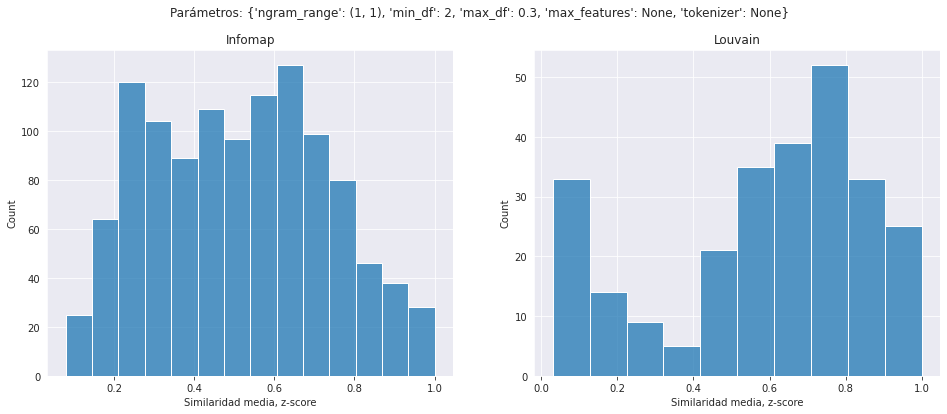

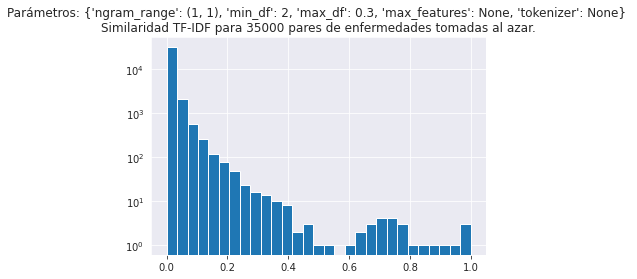

In [30]:
# mean_cluster_similarity(corpus,ids,best_vectorizer,{"ngram_range":(1,1),"min_df":2,"max_df":0.3,"max_features":None,"tokenizer":None})

# Estadística

### Similaridad media entre nodos de un mismo cluster

Text(0.5, 1.0, 'Louvain')

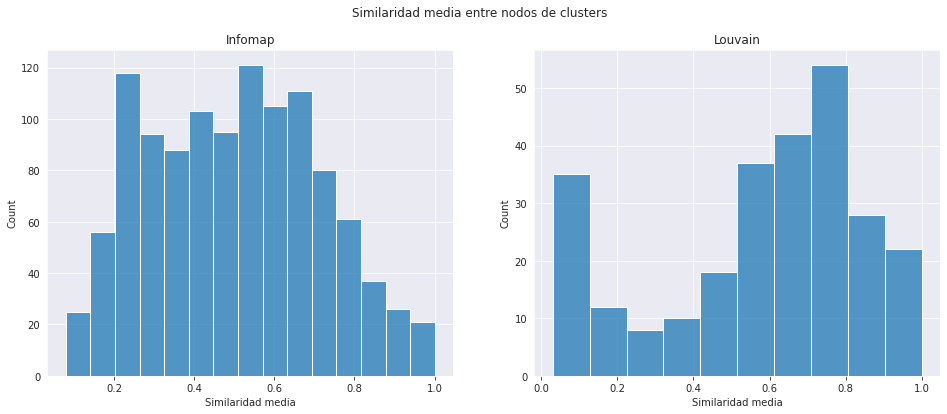

In [62]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Similaridad media entre nodos de clusters")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=infomap_clusters,x="mean_similarity_tfidf", ax=ax[0])
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters,x="mean_similarity_tfidf", ax=ax[1])
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

En vez de tomar la media de similaridad del cluster, veo la distribución del cluster. Comparo distribución contra distribución.

Comparar con distribución: misma cantidad de pares pero al azar. Comparo las dos distribuciones. 
Comparar distribuciones:

T-test para cada cluster: obtengo p valores -> para clusters de tamaño al menos 20

### Similaridad media entre pares de nodos al azar vs pares de nodos al azar **pero que pertenecen a un mismo cluster**

In [8]:
path = data_processed+"tfidf_nodos/"

document_similarity_matrix = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz", path+"rows_tfidf_nodos_0.txt", path+"cols_tfidf_nodos_0.txt")

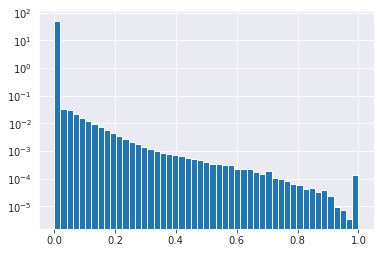

In [11]:
all_values = np.reshape(document_similarity_matrix.values,(1,-1))[0]
# mu = np.mean(all_values)
# sigma = np.std(all_values)
# print(f"Similaridad media para pares al azar {round(mu,2)}")
plot = plt.hist(all_values,bins=np.linspace(0,1,50),log=True, density=True)

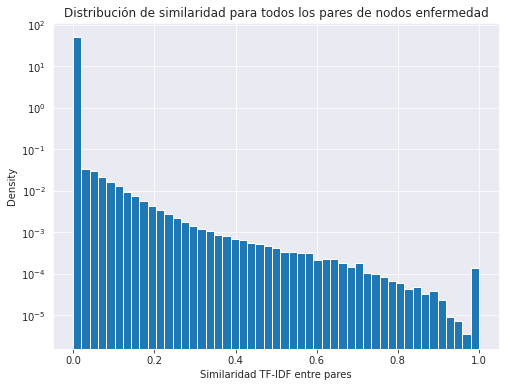

In [22]:
plt.figure(figsize=(8,6))
plot = plt.hist(all_values,bins=np.linspace(0,1,50),log=True, density=True)
plt.title("Distribución de similaridad para todos los pares de nodos enfermedad")
plt.xlabel("Similaridad TF-IDF entre pares")
plt.ylabel("Density")
plt.savefig(tfidf_reports+"similaridad_todos.png",dpi=200)

Similaridad media para pares que comparten cluster: 0.139


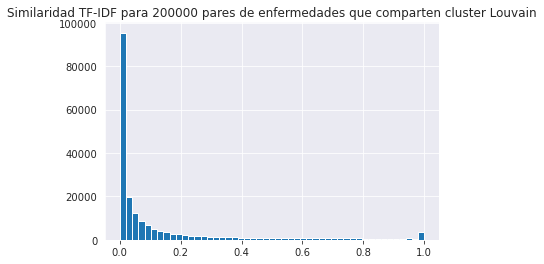

In [84]:
node_indexes = disease_attributes.node_index.values
n_samples = 200000
values_clusters = []
while len(values_clusters) < n_samples:
    nodo_1 = np.random.choice(node_indexes,1)[0]
    cluster = nodos_enfermedades.loc[nodo_1,"comunidades_louvain"]
    posibles = nodos_enfermedades[nodos_enfermedades.comunidades_louvain == cluster].index.values
    nodo_2 = np.random.choice(posibles,1)[0]
    pair_similarity = document_similarity_matrix.loc[nodo_1,nodo_2]
    values_clusters.append(pair_similarity)


media = np.mean(values_clusters)
plt.hist(values_clusters,bins=np.linspace(0,1,50))
plt.title(f"Similaridad TF-IDF para {n_samples} pares de enfermedades que comparten cluster Louvain")
print(f"Similaridad media para pares que comparten cluster: {round(media,3)}")

Similaridad media para pares que comparten cluster Infomap: 0.417


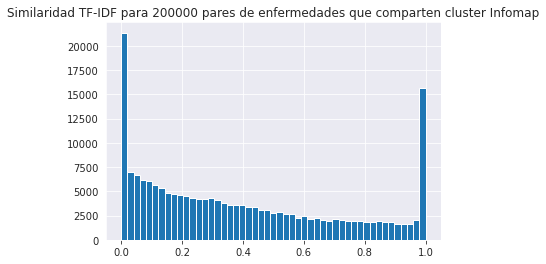

In [89]:
node_indexes = disease_attributes.node_index.values
n_samples = 200000
values_clusters = []
while len(values_clusters) < n_samples:
    nodo_1 = np.random.choice(node_indexes,1)[0]
    cluster = nodos_enfermedades.loc[nodo_1,"comunidades_infomap"]
    posibles = nodos_enfermedades[nodos_enfermedades.comunidades_infomap== cluster].index.values
    nodo_2 = np.random.choice(posibles,1)[0]
    pair_similarity = document_similarity_matrix.loc[nodo_1,nodo_2]
    values_clusters.append(pair_similarity)


media = np.mean(values_clusters)
plt.hist(values_clusters,bins=np.linspace(0,1,50))
plt.title(f"Similaridad TF-IDF para {n_samples} pares de enfermedades que comparten cluster Infomap")
print(f"Similaridad media para pares que comparten cluster Infomap: {round(media,3)}")

Similaridad media para pares que comparten cluster: 0.417


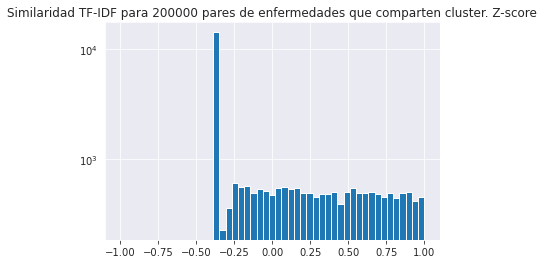

In [92]:
plt.hist(get_z_score(values_clusters,mu,sigma),bins=np.linspace(-1,1,50),log=True)
plt.title(f"Similaridad TF-IDF para {n_samples} pares de enfermedades que comparten cluster. Z-score")
print(f"Similaridad media para pares que comparten cluster: {round(media,3)}")

### Un par de distribuciones que no sé si tenia sentido comparar

Text(0.5, 1.0, 'Cluster 123, tamaño 17')

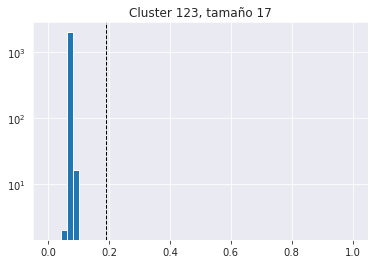

In [17]:
cluster = infomap_clusters.sample(1)
size = cluster["tamaño"].values[0]
mean_sim = cluster["mean_similarity_tfidf"].values[0]
node_indexes = disease_attributes.node_index.values
n_samples = 2000
values = []

while len(values) < n_samples:
    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix.loc[random_cluster,random_cluster]
    mean_random_sim = np.mean(random_cluster_similarity_matrix.values)
    values.append(mean_random_sim)
    # pair = np.random.choice(node_indexes,2)
    # pair_similarity = document_similarity_matrix.loc[pair[0],pair[1]]
    # values.append(pair_similarity)

histogram = plt.hist(values,bins=np.linspace(0,1,50),log=True)
mean_cluster_line = plt.axvline(mean_sim, color='k', linestyle='dashed', linewidth=1)
plt.title(f"Cluster {cluster.comunidad.values[0]}, tamaño {size}")

P-value test 1: 1.6281569259169521e-49
P-value test 2: 0.0


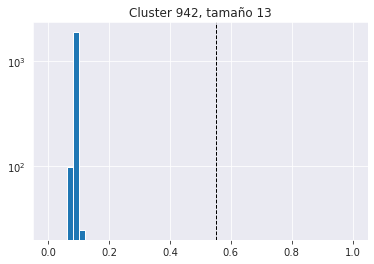

In [17]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind_from_stats

node_indexes = disease_attributes.node_index.values

cluster = infomap_clusters.sample(1)
size = cluster["tamaño"].values[0]
comunidad = cluster["comunidad"].values[0]
mean_sim = cluster["mean_similarity_tfidf"].values[0]

cluster_nodes = nodos_enfermedades[nodos_enfermedades.comunidades_infomap == comunidad].index.values
cluster_similarity_matrix = document_similarity_matrix.loc[cluster_nodes,cluster_nodes]

random_cluster = np.random.choice(node_indexes,size)
random_cluster_similarity_matrix = document_similarity_matrix.loc[random_cluster,random_cluster]

cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]
random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)

n_samples = 2000
values = []

while len(values) < n_samples:
    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix.loc[random_cluster,random_cluster]
    mean_random_sim = np.mean(random_cluster_similarity_matrix.values)
    values.append(mean_random_sim)
    # pair = np.random.choice(node_indexes,2)
    # pair_similarity = document_similarity_matrix.loc[pair[0],pair[1]]
    # values.append(pair_similarity)

histogram = plt.hist(values,bins=np.linspace(0,1,50),log=True)
mean_cluster_line = plt.axvline(mean_sim, color='k', linestyle='dashed', linewidth=1)
plt.title(f"Cluster {cluster.comunidad.values[0]}, tamaño {size}")

print(f"P-value test 1: {pvalue_1}")


cluster_mean, cluster_std, cluster_n = np.mean(cluster_sample), np.std(random_sample), len(cluster_sample)
random_mean, random_std, random_n = np.mean(values), np.std(values), len(values)

tvalue_2, pvalue_2 = ttest_ind_from_stats(cluster_mean, cluster_std, cluster_n, random_mean, random_std, random_n)
print(f"P-value test 2: {pvalue_2}")

### P valores

Dado un cluster de N nodos, tengo una muestra de tamaño NxN de valores similaridad pair-wise entre nodos. Extraigo N nodos al azar del conjunto de *todos los nodos posibles*, con esos tengo otra muestra de NxN de valores de similaridad pair-wise entre nodos.

Usando la función de scipy puedo comparar las dos muestras y me da el p-valor. 

Lo repito para todos los clusters y grafico los p-valores que obtengo.

In [27]:
display(pd.DataFrame(cluster_sample).describe())
display(pd.DataFrame(random_sample).describe())

,0
count,169.000000
mean,0.554776
std,0.216164
min,0.263836
25%,0.389880
50%,0.489834
75%,0.627061
max,1.000000


,0
count,169.000000
mean,0.092829
std,0.264520
min,0.000000
25%,0.000000
50%,0.007838
75%,0.023895
max,1.000000


Elijo clusters al azar para graficarlo y ver como se comportan algunos ejemplos

Cluster id: 72
P-valor: 0.0
Tamaño de la(s) muestra(s): 841 
Tamaño del cluster 29


,cluster_sample,random_sample
count,841.000000,841.000000
mean,0.690285,0.046131
std,0.245404,0.181956
min,0.173631,0.000000
25%,0.520324,0.000000
50%,0.764988,0.000000
75%,0.892875,0.019509
max,1.000000,1.000000


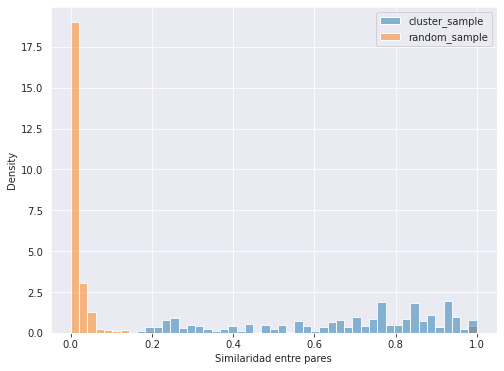

In [437]:
from scipy.stats import ttest_ind

node_indexes = disease_attributes.node_index.values

cluster = louvain_clusters.sample(1)
size = cluster["tamaño"].values[0]
comunidad = cluster["comunidad"].values[0]

cluster_nodes = disease_attributes[disease_attributes.comunidades_louvain == comunidad].node_index.values
cluster_similarity_matrix = document_similarity_matrix[0].loc[cluster_nodes,cluster_nodes]
cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

random_cluster = np.random.choice(node_indexes,size)
random_cluster_similarity_matrix = document_similarity_matrix[0].loc[random_cluster,random_cluster]
random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)

data = pd.DataFrame([cluster_sample,random_sample]).T.rename(columns={0:"cluster_sample",1:"random_sample"})
fig, ax = plt.subplots(figsize=(8,6))
hist1 = sns.histplot(data=data,bins=np.linspace(0,1,50),ax=ax, stat="density")
ax.set_xlabel("Similaridad entre pares")

print(f"Cluster id: {comunidad}\nP-valor: {round(pvalue_1,3)}\nTamaño de la(s) muestra(s): {len(cluster_sample)} \nTamaño del cluster {size}")

display(pd.DataFrame(data).describe())
# display(pd.DataFrame(random_sample).describe())

In [440]:
cluster[['comunidad', 'tamaño', 'mean_similarity_mono', 'mean_similarity_bi',
       'mean_similarity_tri', 'entropia_1', 'entropia_2', 'entropia_3',
       'top_monogram', 'top_monogram_score', 'top_bigram', 'top_bigram_score',
       'top_trigram', 'top_trigram_score', 'top_5_monograms', 'top_5_bigrams',
       'top_5_trigrams']]

,comunidad,tamaño,mean_similarity_mono,mean_similarity_bi,mean_similarity_tri,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,top_5_monograms,top_5_bigrams,top_5_trigrams
53,72,29,0.69,0.65,0.34,0.37,0.33,0.32,amelogenesis,0.72,amelogenesis imperfecta,0.96,calcium salt renal,0.32,"[amelogenesis, imperfecta, enamel, dental, teeth]","[amelogenesis imperfecta, dental enamel, ename...","[delayed tooth eruption, calcium salt renal, c..."


Ejemplos posibles: louvain 47, louvain 72, infomap 179

In [362]:
node_indexes = disease_attributes.node_index.values

pvalues_infomap = {}
for comunidad in infomap_clusters.comunidad.values:
    size = infomap_clusters.loc[infomap_clusters.comunidad == comunidad,"tamaño"].values[0]

    cluster_nodes = disease_attributes[disease_attributes.comunidades_infomap == comunidad].node_index.values
    cluster_similarity_matrix = document_similarity_matrix[0].loc[cluster_nodes,cluster_nodes]
    cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix[0].loc[random_cluster,random_cluster]
    random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

    tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)
    pvalues_infomap[comunidad] = round(pvalue_1,3)


pvalues_louvain = {}
for comunidad in louvain_clusters.comunidad.values:
    size = louvain_clusters.loc[louvain_clusters.comunidad == comunidad,"tamaño"].values[0]

    cluster_nodes = disease_attributes[disease_attributes.comunidades_louvain == comunidad].node_index.values
    cluster_similarity_matrix = document_similarity_matrix[0].loc[cluster_nodes,cluster_nodes]
    cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix[0].loc[random_cluster,random_cluster]
    random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

    tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)
    pvalues_louvain[comunidad] = round(pvalue_1,3)

louvain_clusters = pd.merge(louvain_clusters,pd.Series(pvalues_louvain,name="p_value"),left_on="comunidad",right_index=True)
infomap_clusters = pd.merge(infomap_clusters,pd.Series(pvalues_infomap,name="p_value"),left_on="comunidad",right_index=True)

Text(0.5, 0, 'P-values')

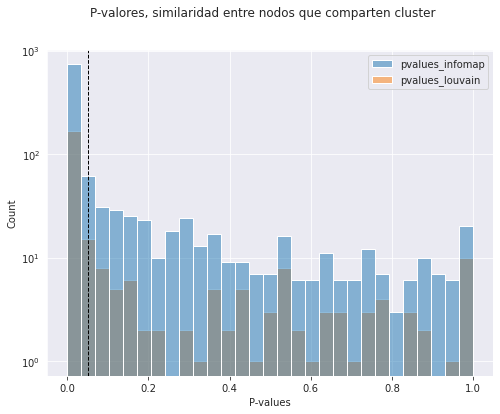

In [462]:
data = pd.DataFrame([pvalues_infomap.values(),pvalues_louvain.values()]).T.rename(columns={0:"pvalues_infomap",1:"pvalues_louvain"})
fig, ax = plt.subplots(figsize=(8,6))
hist1 = sns.histplot(data=data,bins=np.linspace(0,data.max().max(),30),log_scale=(False,True))
fig.suptitle("P-valores, similaridad entre nodos que comparten cluster")
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel("P-values")

In [456]:
node_indexes = disease_attributes.node_index.values

pvalues_infomap = {}
for comunidad in infomap_clusters.comunidad.values:
    size = infomap_clusters.loc[infomap_clusters.comunidad == comunidad,"tamaño"].values[0]

    cluster_nodes = disease_attributes[disease_attributes.comunidades_infomap == comunidad].node_index.values
    cluster_similarity_matrix = document_similarity_matrix[1].loc[cluster_nodes,cluster_nodes]
    cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix[1].loc[random_cluster,random_cluster]
    random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

    tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)
    pvalues_infomap[comunidad] = round(pvalue_1,3)


pvalues_louvain = {}
for comunidad in louvain_clusters.comunidad.values:
    size = louvain_clusters.loc[louvain_clusters.comunidad == comunidad,"tamaño"].values[0]

    cluster_nodes = disease_attributes[disease_attributes.comunidades_louvain == comunidad].node_index.values
    cluster_similarity_matrix = document_similarity_matrix[1].loc[cluster_nodes,cluster_nodes]
    cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix[1].loc[random_cluster,random_cluster]
    random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

    tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)
    pvalues_louvain[comunidad] = round(pvalue_1,3)

louvain_clusters = pd.merge(louvain_clusters,pd.Series(pvalues_louvain,name="p_value_bigrams"),left_on="comunidad",right_index=True)
infomap_clusters = pd.merge(infomap_clusters,pd.Series(pvalues_infomap,name="p_value_bigrams"),left_on="comunidad",right_index=True)

Text(0.5, 0, 'P-values')

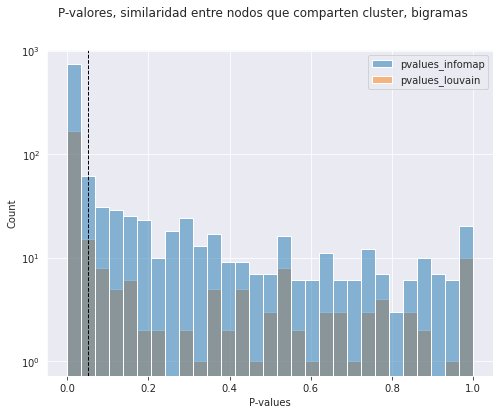

In [461]:
data = pd.DataFrame([pvalues_infomap.values(),pvalues_louvain.values()]).T.rename(columns={0:"pvalues_infomap",1:"pvalues_louvain"})
fig, ax = plt.subplots(figsize=(8,6))
hist1 = sns.histplot(data=data,bins=np.linspace(0,data.max().max(),30), log_scale=(False,True))
fig.suptitle("P-valores, similaridad entre nodos que comparten cluster, bigramas")
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel("P-values")

In [469]:
node_indexes = disease_attributes.node_index.values

pvalues_infomap = {}
for comunidad in infomap_clusters.comunidad.values:
    size = infomap_clusters.loc[infomap_clusters.comunidad == comunidad,"tamaño"].values[0]

    cluster_nodes = disease_attributes[disease_attributes.comunidades_infomap == comunidad].node_index.values
    cluster_similarity_matrix = document_similarity_matrix[2].loc[cluster_nodes,cluster_nodes]
    cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix[2].loc[random_cluster,random_cluster]
    random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

    tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)
    pvalues_infomap[comunidad] = round(pvalue_1,3)


pvalues_louvain = {}
for comunidad in louvain_clusters.comunidad.values:
    size = louvain_clusters.loc[louvain_clusters.comunidad == comunidad,"tamaño"].values[0]

    cluster_nodes = disease_attributes[disease_attributes.comunidades_louvain == comunidad].node_index.values
    cluster_similarity_matrix = document_similarity_matrix[2].loc[cluster_nodes,cluster_nodes]
    cluster_sample = np.reshape(cluster_similarity_matrix.values,(1,-1))[0]

    random_cluster = np.random.choice(node_indexes,size)
    random_cluster_similarity_matrix = document_similarity_matrix[2].loc[random_cluster,random_cluster]
    random_sample = np.reshape(random_cluster_similarity_matrix.values,(1,-1))[0]

    tvalue_1,pvalue_1 = ttest_ind(cluster_sample,random_sample)
    pvalues_louvain[comunidad] = round(pvalue_1,3)

louvain_clusters = pd.merge(louvain_clusters,pd.Series(pvalues_louvain,name="p_value_trigrams"),left_on="comunidad",right_index=True)
infomap_clusters = pd.merge(infomap_clusters,pd.Series(pvalues_infomap,name="p_value_trigrams"),left_on="comunidad",right_index=True)

Text(0.5, 0, 'P-values')

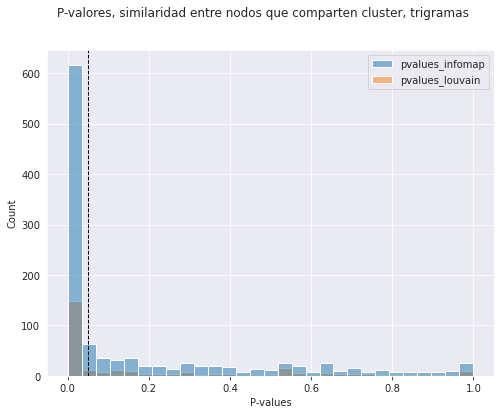

In [466]:
data = pd.DataFrame([pvalues_infomap.values(),pvalues_louvain.values()]).T.rename(columns={0:"pvalues_infomap",1:"pvalues_louvain"})
fig, ax = plt.subplots(figsize=(8,6))
hist1 = sns.histplot(data=data,bins=np.linspace(0,data.max().max(),30))
fig.suptitle("P-valores, similaridad entre nodos que comparten cluster, trigramas")
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel("P-values")

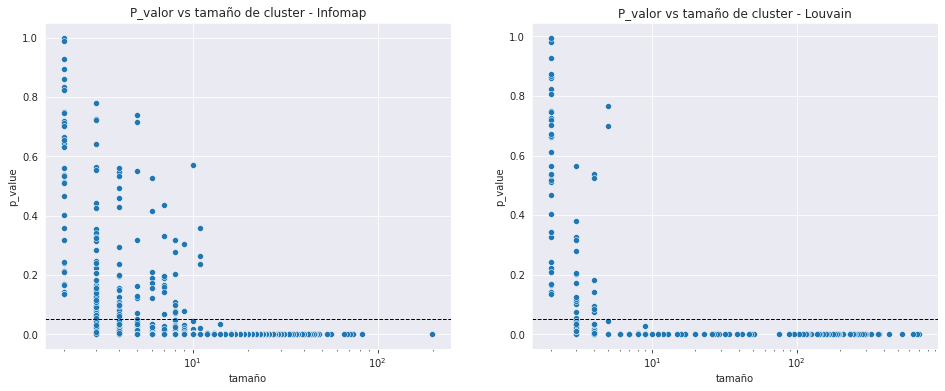

In [464]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
plot1 = sns.scatterplot(data=infomap_clusters,x="tamaño",y="p_value",ax=axs[0])
axs[0].set_xscale('log')
axs[0].set_title("P_valor vs tamaño de cluster - Infomap")
axs[0].axhline(0.05, color='k', linestyle='dashed', linewidth=1)
# ax.set_yscale('log')

plot1 = sns.scatterplot(data=louvain_clusters,x="tamaño",y="p_value",ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_title("P_valor vs tamaño de cluster - Louvain")
axs[1].axhline(0.05, color='k', linestyle='dashed', linewidth=1)

Graficos pero solo para clusters de tamaño mayor a 10

In [493]:
data

,p_value,p_value
0,0.000,0.0
1,0.000,0.0
2,0.000,0.0
3,0.000,0.0
4,0.000,0.0
...,...,...
469,0.002,NaN
470,0.000,NaN
471,0.000,NaN
472,0.000,NaN


Text(0.5, 0, 'P-values')

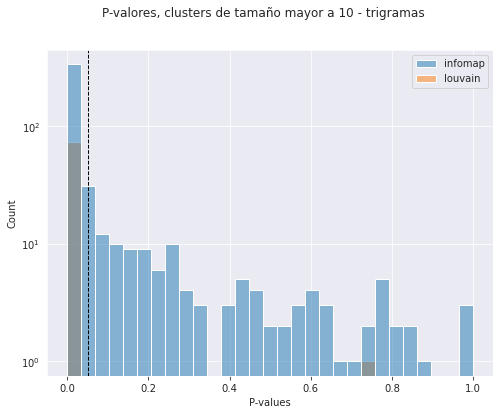

In [499]:
data_infomap = infomap_clusters.loc[infomap_clusters.tamaño >=10,["p_value","p_value_bigrams","p_value_trigrams"]]
data_louvain = louvain_clusters.loc[louvain_clusters.tamaño >=10,["p_value","p_value_bigrams","p_value_trigrams"]]

data = pd.DataFrame([pd.Series(data_infomap.p_value_trigrams,name="infomap"), pd.Series(data_louvain.p_value_trigrams,name="louvain")]).T

fig, ax = plt.subplots(figsize=(8,6))
hist1 = sns.histplot(data=data,bins=np.linspace(0,data_infomap.max().max(),30),log_scale=(False,True))
fig.suptitle("P-valores, clusters de tamaño mayor a 10 - trigramas")
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel("P-values")

# LSA: Latent Semantic Analysis - Reducción de dimensionalidad con SVD

## Genero el modelo y aplico la reducción de dimensionalidad

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
lsa_reports = "../../reports/lsa/"

In [6]:
matrix_path = data_processed+"tfidf_matrices/matriz_tfidf_louvain_0.npz"
col_path = data_processed+"tfidf_matrices/cols_tfidf_louvain_0.txt"
row_path = data_processed+"tfidf_matrices/rows_tfidf_louvain_0.txt"

dtm_louvain_mono = load_sparse_dataframe(matrix_path,row_path,col_path)

In [12]:
matrix_path = data_processed+"tfidf_matrices/matriz_tfidf_infomap_0.npz"
col_path = data_processed+"tfidf_matrices/cols_tfidf_infomap_0.txt"
row_path = data_processed+"tfidf_matrices/rows_tfidf_infomap_0.txt"

dtm_infomap_mono = load_sparse_dataframe(matrix_path,row_path,col_path)

In [10]:
# matrix_path = data_processed+"tfidf_matrices/matriz_nodos_tfidf_0.npz"
# col_path = data_processed+"tfidf_matrices/cols_tfidf_nodos_0.txt"
# row_path = data_processed+"tfidf_matrices/rows_tfidf_nodos_0.txt"

# dtm_nodos_mono = load_sparse_dataframe(matrix_path,row_path,col_path)

### Scree plot - elijo num componentes

#### Nodos

In [15]:
X_nodos = dtm_nodos_mono.sparse.to_dense()

svd = TruncatedSVD(n_components=2000)
lsa = svd.fit(X_nodos)

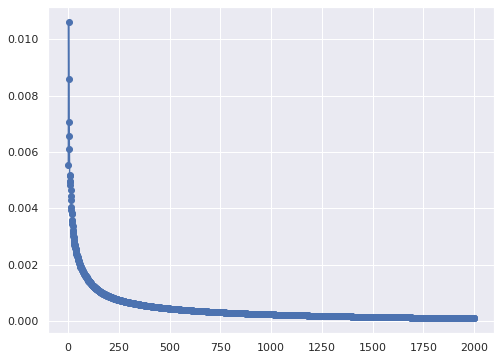

In [16]:
y = lsa.explained_variance_ratio_
x = np.linspace(1,len(y),len(y))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,y,"o-")

Alcanzo el 80% de varianza acumlada con 1423 componentes


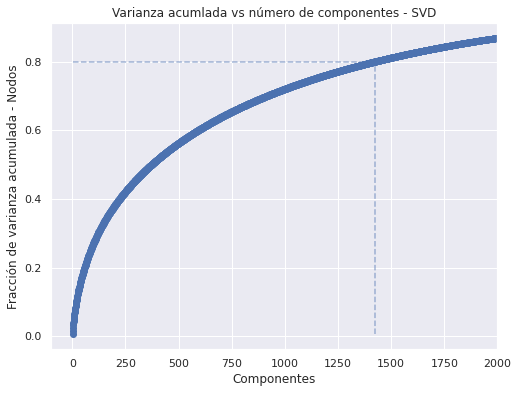

In [18]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=2000)
ax.set_ylabel('Fracción de varianza acumulada - Nodos')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 80% de varianza acumlada con {corte} componentes")
# fig.savefig(lsa_reports+"evr_plot.png")

Número de componentes: 250

#### Clusters

In [13]:
X_infomap = dtm_infomap_mono.sparse.to_dense()

svd_infomap = TruncatedSVD(n_components=1000)
lsa_infomap = svd_infomap.fit(X_infomap)

X_louvain = dtm_louvain_mono.sparse.to_dense()

svd_louvain = TruncatedSVD(n_components=1000)
lsa_louvain = svd_louvain.fit(X_louvain)

Alcanzo el 90% de varianza acumlada con 477 componentes
Alcanzo el 90% de varianza acumlada con 154 componentes


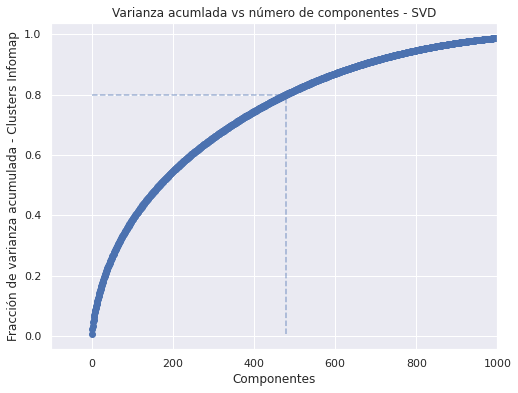

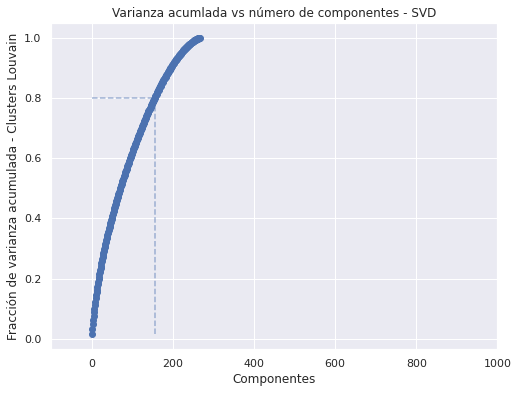

In [16]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa_infomap.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=1000)
ax.set_ylabel('Fracción de varianza acumulada - Clusters Infomap')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")
# fig.savefig(lsa_reports+"evr_plot.png")


# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa_louvain.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=1000)
ax.set_ylabel('Fracción de varianza acumulada - Clusters Louvain')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")

In [17]:
corte_infomap = 477
corte_louvain = 154

Elegir punto de mayor derivada en lugar de 90% arbitrario. Alrededor de 500 puede ser. 

Criterio del codo: varianza explicada x cada componente

Me quedo con un modelo de 70% de varianza, más que eso podría estar metiendo ruido. 

### Armo el modelo

### Clusters

In [19]:
svd_infomap = TruncatedSVD(n_components=corte_infomap)
lsa_infomap = svd_infomap.fit(X_infomap)
lsa_infomap_data = lsa_infomap.transform(X_infomap)

svd_louvain = TruncatedSVD(n_components=corte_louvain)
lsa_louvain = svd_louvain.fit(X_louvain)
lsa_louvain_data = lsa_louvain.transform(X_louvain)

In [27]:
# most important words for each topic
vocab_louvain = X_louvain.columns.values
component_data = {}

for i, comp in enumerate(lsa_louvain.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_louvain, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_louvain = pd.DataFrame.from_dict(component_data,orient="index")

In [28]:
# most important words for each topic
vocab_infomap = X_infomap.columns.values
component_data = {}

for i, comp in enumerate(lsa_infomap.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_infomap, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_infomap = pd.DataFrame.from_dict(component_data,orient="index")

### Nodos

In [19]:
svd = TruncatedSVD(n_components=1400)
lsa = svd.fit(X_nodos)

lsa_data = lsa.transform(X_nodos)

In [20]:
# most important words for each topic
vocab = X_nodos.columns.values
component_data = {}

for i, comp in enumerate(lsa.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab = pd.DataFrame.from_dict(component_data,orient="index")

In [165]:
# component_vocab.to_pickle(lsa_reports+"component_vobab.pkl")
# np.savetxt(lsa_reports+"vectorized_data.txt",lsa_data)

In [26]:
sorted(zip(vocab,lsa.components_[5]), key= lambda x:x[1], reverse=True)[:10]

[('spastic', 0.21968514253271082),
 ('hmsn', 0.21523630103548272),
 ('paraplegia', 0.1921745320669543),
 ('neuropathy', 0.18458628489198264),
 ('sensory', 0.17380946669154065),
 ('nerve', 0.15861468009932417),
 ('hereditary', 0.15518732194620435),
 ('motor', 0.14889719702016121),
 ('charcot', 0.13594197413847972),
 ('marie', 0.13576283858604699)]

In [27]:
component_vocab

,wordlist,scorelist
0,"[autosomal, recessive, cell, muscle, rare, inc...","[0.254, 0.186, 0.151, 0.139, 0.135, 0.134, 0.1..."
1,"[autosomal, recessive, deafness, retardation, ...","[0.333, 0.249, 0.235, 0.16, 0.153, 0.153, 0.12..."
2,"[deafness, autosomal, neoplasm, recessive, car...","[0.312, 0.298, 0.234, 0.225, 0.219, 0.21, 0.18..."
3,"[dystrophy, retinitis, pigmentosa, deafness, r...","[0.359, 0.274, 0.27, 0.215, 0.185, 0.15, 0.149..."
4,"[retardation, mental, dystrophy, link, intelle...","[0.325, 0.308, 0.244, 0.229, 0.2, 0.188, 0.153..."
...,...,...
1395,"[hemorrhoid, intraductal, asperger, hypokalemi...","[0.139, 0.077, 0.076, 0.075, 0.073, 0.062, 0.0..."
1396,"[hyperalphalipoproteinemia, granule, endocervi...","[0.104, 0.08, 0.074, 0.066, 0.065, 0.059, 0.05..."
1397,"[chilblain, hyperalphalipoproteinemia, sandhof...","[0.111, 0.103, 0.084, 0.073, 0.057, 0.056, 0.0..."
1398,"[hyperalphalipoproteinemia, peroxidase, reticu...","[0.165, 0.079, 0.077, 0.077, 0.072, 0.07, 0.06..."


### Obtengo la matriz de similaridad

In [13]:
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [11]:
# lsa_data_dense = lsa_data.toarray()
# lsa_similarity_matrix = cosine_similarity(lsa_data_dense,lsa_data_dense)

In [13]:
# lsa_similarity_matrix_sparse = sparse.csr_matrix(lsa_similarity_matrix)
# sparse.save_npz(lsa_reports+"lsa_similarity_matrix.npz",lsa_similarity_matrix_sparse)

## Checkpoint

Guardé los resultados para seguir desde acá y que el notebook no se ponga tan pesado

In [6]:
# component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
# lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [29]:
from wordcloud import WordCloud

def plot_component_vocab(component,component_vocab):
    n = component
    fig,ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=component_vocab.loc[n,"wordlist"], y=component_vocab.loc[n,"scorelist"], ax=ax)
    ax.set_title(f"Top 10 términos de la componente {n}")
    plt.xticks(rotation=45)
    plt.tight_layout()

def wordcloud_component_vocab(component,component_vocab):
    n = component
    words = component_vocab.loc[n,"wordlist"]
    scores = component_vocab.loc[n,"scorelist"]
    wordcloud_dict = {word:score for (word,score) in zip(words,scores)}
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

In [76]:
component_vocab_infomap

,wordlist,scorelist
0,"[neoplasm, tumor, carcinoma, muscle, malignant...","[0.169, 0.169, 0.169, 0.158, 0.153, 0.148, 0.1..."
1,"[carcinoma, neoplasm, malignant, tumor, adenoc...","[0.377, 0.298, 0.29, 0.277, 0.13, 0.122, 0.122..."
2,"[dysplasia, short, bone, anomaly, facial, reta...","[0.305, 0.184, 0.155, 0.149, 0.138, 0.129, 0.1..."
3,"[muscle, dystrophy, muscular, myopathy, weakne...","[0.415, 0.323, 0.243, 0.22, 0.2, 0.11, 0.088, ..."
4,"[deficiency, seizure, acid, ataxia, mitochondr...","[0.267, 0.177, 0.132, 0.119, 0.117, 0.107, 0.1..."
...,...,...
472,"[hemorrhoid, vitreoretinopathy, myelodysplasti...","[0.096, 0.08, 0.08, 0.078, 0.075, 0.074, 0.071..."
473,"[holoprosencephaly, hypomagnesemia, proline, i...","[0.168, 0.077, 0.073, 0.069, 0.066, 0.065, 0.0..."
474,"[leukocyte, adhesion, hemimelia, hemorrhoid, d...","[0.086, 0.085, 0.078, 0.077, 0.074, 0.073, 0.0..."
475,"[proline, liposarcoma, soft, myosin, neuroendo...","[0.086, 0.083, 0.076, 0.076, 0.075, 0.073, 0.0..."


In [77]:
component_vocab_louvain

,wordlist,scorelist
0,"[cell, skin, muscle, bone, infection, blood, r...","[0.177, 0.167, 0.142, 0.132, 0.131, 0.129, 0.1..."
1,"[cell, tumor, neoplasm, malignant, carcinoma, ...","[0.298, 0.184, 0.178, 0.167, 0.14, 0.123, 0.11..."
2,"[susceptibility, link, mental, intellectual, d...","[0.474, 0.433, 0.241, 0.209, 0.186, 0.171, 0.1..."
3,"[renal, dysplasia, kidney, malformation, bone,...","[0.382, 0.257, 0.236, 0.217, 0.18, 0.12, 0.118..."
4,"[susceptibility, dystrophy, muscle, renal, mus...","[0.471, 0.3, 0.229, 0.17, 0.156, 0.111, 0.103,..."
...,...,...
149,"[malaria, phalanx, brachydactyly, xiii, prolin...","[0.128, 0.125, 0.115, 0.112, 0.11, 0.094, 0.09..."
150,"[asthma, dissolution, glioma, removal, osteoly...","[0.133, 0.12, 0.118, 0.115, 0.115, 0.111, 0.10..."
151,"[hepato, hepatitis, enteric, paroxysmal, hmsn,...","[0.113, 0.106, 0.101, 0.092, 0.091, 0.087, 0.0..."
152,"[fracture, scoliosis, acidosis, va, joubert, t...","[0.124, 0.113, 0.097, 0.091, 0.088, 0.085, 0.0..."


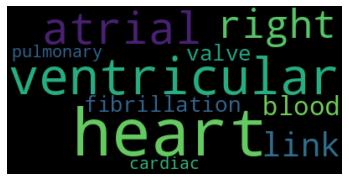

In [37]:
wordcloud_component_vocab(8,component_vocab_louvain)

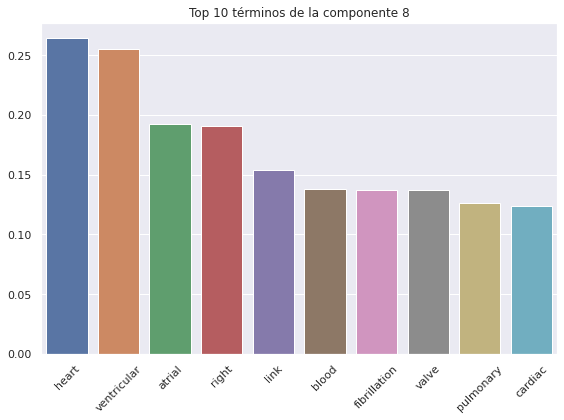

In [38]:
plot_component_vocab(8,component_vocab_louvain)

In [52]:
lsa_infomap_df = pd.DataFrame(lsa_infomap_data, index=X_infomap.index.values)
lsa_louvain_df = pd.DataFrame(lsa_louvain_data, index=X_louvain.index.values)

In [57]:
lsa_louvain_df.loc[random_cluster].idxmax()

0

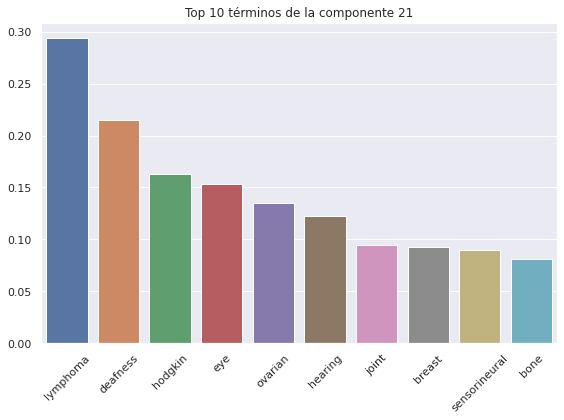

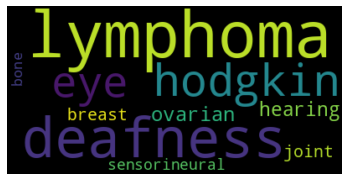

,node_index,comunidades_infomap,comunidades_louvain,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
501,3885,1054.0,182.0,18876_6430,mantle cell lymphoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,primekg
4944,23675,1054.0,182.0,C0334634,"Malignant lymphoma, lymphocytic, intermediate ...",disease,18876.0,mantle cell lymphoma,Mantle cell lymphoma is a rare form of maligna...,A form of non-Hodgkin lymphoma having a usuall...,Mantle cell lymphoma is a rare form of maligna...,C04;C20;C15,Neoplasms; Immune System Diseases; Hemic and L...,disgenet
5760,24916,1054.0,182.0,C0555202,"Malignant lymphoma - lymphocytic, intermediate...",disease,18876.0,mantle cell lymphoma,Mantle cell lymphoma is a rare form of maligna...,NaN,Mantle cell lymphoma is a rare form of maligna...,NaN,NaN,disgenet
12368,33908,1054.0,182.0,C4721414,Mantle cell lymphoma,disease,18876.0,mantle cell lymphoma,Mantle cell lymphoma is a rare form of maligna...,"An aggressive, usually diffuse non-Hodgkin lym...",Mantle cell lymphoma is a rare form of maligna...,C04;C20;C15,Neoplasms; Immune System Diseases; Hemic and L...,disgenet


In [75]:
random_cluster = np.random.choice(X_infomap.index.values,1)[0]
top_component = lsa_infomap_df.loc[random_cluster].idxmax()

plot_component_vocab(top_component,component_vocab_infomap)
wordcloud_component_vocab(top_component,component_vocab_infomap)
disease_attributes[disease_attributes.comunidades_infomap == random_cluster]

## Veo ejemplos al azar

In [82]:
node_ids = disease_attributes.node_index.values

In [83]:
node_ids

array([    7,    17,    19, ..., 34192, 34194, 34195])

array(['Giant Cell Tumor of Soft Tissue',
       'A painless, well circumscribed tumor arising in soft tissue, usually of the upper and lower extremities. Morphologically, it is characterized by a multinodular growth pattern. The cellular infiltrate is composed of mononuclear round or oval cells and multinucleated osteoclast-like giant cells, in a rich vascular stroma. It rarely metastasizes.',
       'A painless, well circumscribed tumor arising in soft tissue, usually of the upper and lower extremities. Morphologically, it is characterized by a multinodular growth pattern. The cellular infiltrate is composed of mononuclear round or oval cells and multinucleated osteoclast-like giant cells, in a rich vascular stroma. It rarely metastasizes.',
       nan], dtype=object)

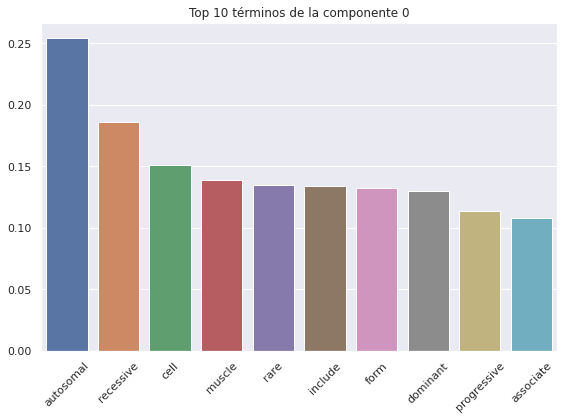

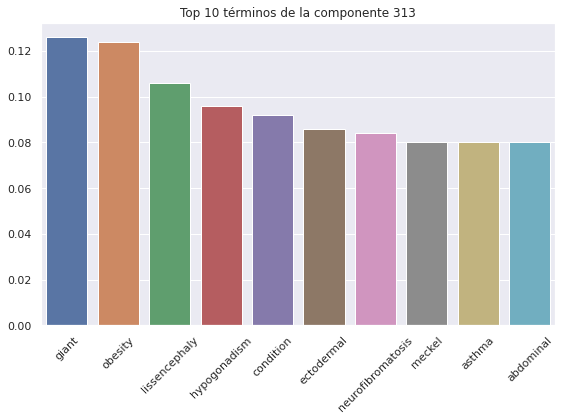

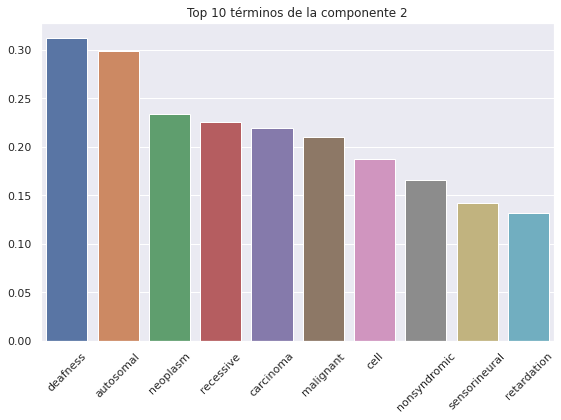

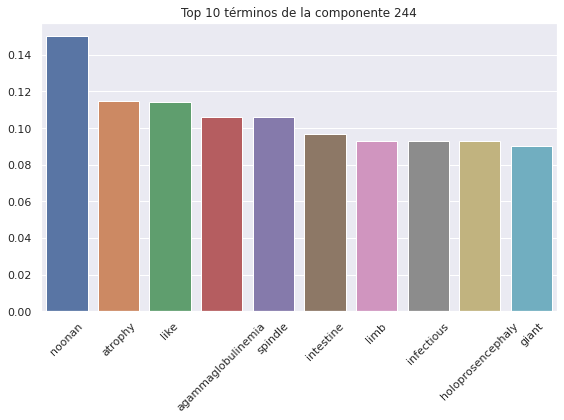

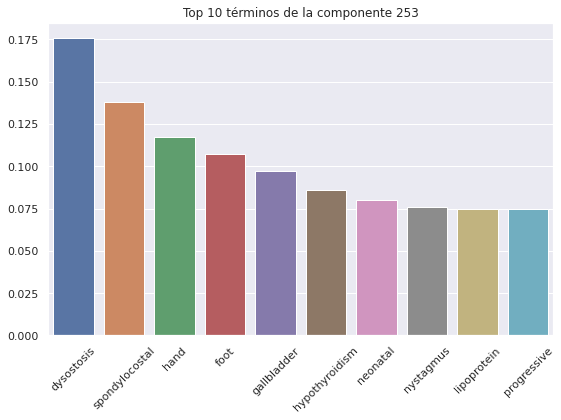

In [40]:
nodo = np.random.choice(range(lsa_data.shape[0]),1)[0]
vector_lsa = lsa_data[nodo]
top_10_components_idx = np.argsort(-vector_lsa)[0:10]
top_10_components_score = vector_lsa[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:5]:
    plot_component_vocab(component)

## Vuelvo a ver similaridad entre pares

### Similaridad media entre nodos de un mismo cluster

In [13]:
ids = disease_attributes.node_index.values
lsa_similarity_matrix_df = pd.DataFrame.sparse.from_spmatrix(lsa_similarity_matrix, index=ids, columns=ids)

In [63]:
lsa_similarity_matrix_df

,7,17,19,28,88,89,91,106,183,188,...,34182,34183,34185,34188,34189,34190,34191,34192,34194,34195
7,1.000000,0.000002,0.001763,0.000614,0.001631,-0.000182,-0.000201,0.000653,0.000188,-0.000031,...,0.001485,0.000112,0.002304,-0.001335,-0.000645,-0.000307,0.000831,0.002702,0.002008,0.000296
17,0.000002,1.000000,-0.000079,0.000007,-0.000071,-0.000047,0.000035,0.000053,-0.000003,-0.000081,...,-0.000041,0.000012,-0.000040,0.000004,-0.000060,0.000018,0.000016,0.000021,0.000061,0.000053
19,0.001763,-0.000079,1.000000,0.000511,0.004774,0.000556,-0.002102,0.002323,-0.000423,-0.001228,...,0.001589,-0.000429,-0.002314,-0.001586,-0.001631,0.000714,-0.002806,-0.001280,-0.003048,0.001487
28,0.000614,0.000007,0.000511,1.000000,0.002271,0.000382,0.000140,0.001643,0.000232,-0.000265,...,-0.005063,-0.000888,-0.001047,0.000245,-0.000240,0.002221,-0.000245,-0.002798,0.002412,0.001021
88,0.001631,-0.000071,0.004774,0.002271,1.000000,-0.001748,-0.000188,-0.000136,-0.000184,0.002003,...,0.003531,0.000431,-0.002516,-0.001166,0.001749,-0.002552,-0.001062,0.000441,0.005062,-0.000978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34190,-0.000307,0.000018,0.000714,0.002221,-0.002552,0.002656,-0.000307,-0.000772,-0.000140,0.001153,...,0.060158,0.208307,0.386032,0.103193,0.008251,1.000000,0.061509,0.016133,0.041553,0.098118
34191,0.000831,0.000016,-0.002806,-0.000245,-0.001062,-0.002907,-0.000186,-0.001063,0.000710,0.001228,...,0.054787,0.061648,0.022907,0.060594,0.014811,0.061509,1.000000,0.071094,0.017896,0.025391
34192,0.002702,0.000021,-0.001280,-0.002798,0.000441,0.004561,0.000441,0.000928,0.000036,0.001497,...,0.012355,0.021942,0.010441,0.014397,0.014057,0.016133,0.071094,1.000000,0.438249,0.046649
34194,0.002008,0.000061,-0.003048,0.002412,0.005062,-0.002013,0.000973,-0.000903,0.000837,0.001863,...,0.015194,0.015413,0.017768,0.009023,0.013123,0.041553,0.017896,0.438249,1.000000,0.031406


In [14]:
def mean_similarity(similarity_matrix, cluster, algoritmo):
    nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
    return round(np.mean(cluster_matrix.values), 2)

In [15]:
tamaños_louvain = nodos_enfermedades.comunidades_louvain.value_counts()
tamaños_infomap = nodos_enfermedades.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [17]:
infomap_similarity = pd.Series({cluster:mean_similarity(lsa_similarity_matrix_df, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="mean_similarity_lsa")
louvain_similarity = pd.Series({cluster:mean_similarity(lsa_similarity_matrix_df, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="mean_similarity_lsa")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

Text(0.5, 1.0, 'Louvain')

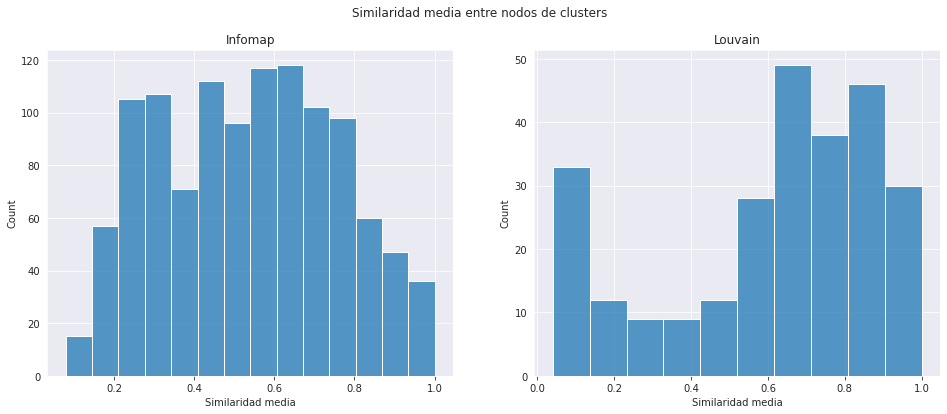

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Similaridad media entre nodos de clusters")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=infomap_clusters,x="mean_similarity_lsa", ax=ax[0])
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters,x="mean_similarity_lsa", ax=ax[1])
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

Similaridad media: 0.46


/tmp/ipykernel_31847/3717346727.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


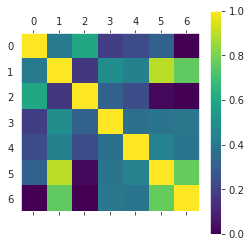

In [59]:
algoritmo = "comunidades_infomap"
cluster = tamaños_infomap.sample(1).index[0]
nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
plt.matshow(lsa_similarity_matrix_df.loc[nodos_cluster,nodos_cluster],vmin=0, vmax=1, cmap="viridis")
plt.grid(False)
plt.colorbar()

mean_sim = infomap_clusters.loc[infomap_clusters.comunidad == cluster, "mean_similarity_lsa"].values[0]
print(f"Similaridad media: {mean_sim}")

In [61]:
disease_attributes[disease_attributes.node_index == 20524]

,node_index,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
2682,20524,C0032308,Staphylococcal Pneumonia,disease,5970.0,staphylococcal pneumonia,Pneumonia caused by infections with bacteria o...,Pneumonia caused by infections with bacteria o...,NaN,C01;C08,Infections; Respiratory Tract Diseases,disgenet


array(['Staphylococcal Pneumonia',
       'Pneumonia caused by infections with bacteria of the genus staphylococcus, usually with staphylococcus aureus.',
       'Pneumonia caused by infections with bacteria of the genus staphylococcus, usually with staphylococcus aureus.',
       nan], dtype=object)

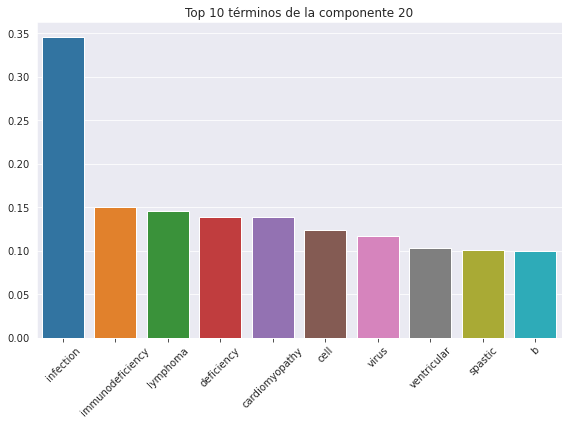

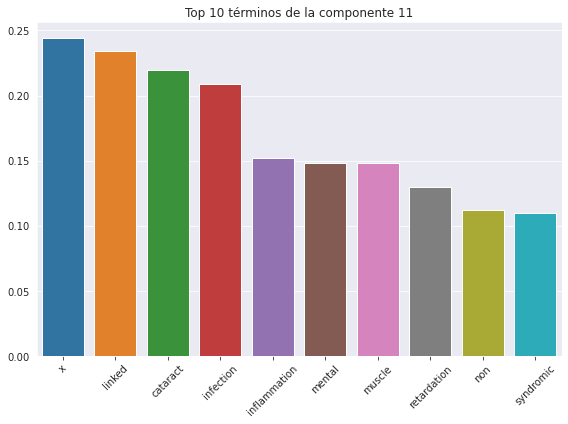

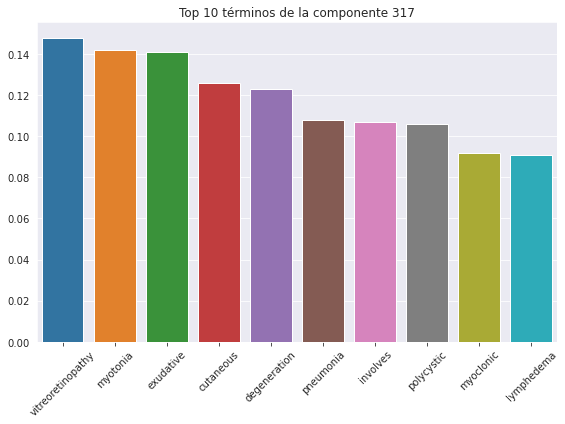

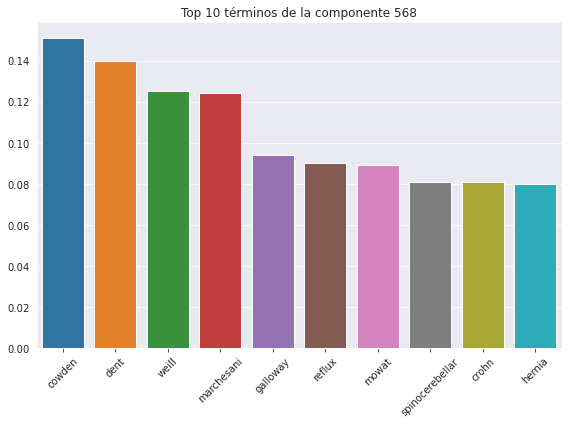

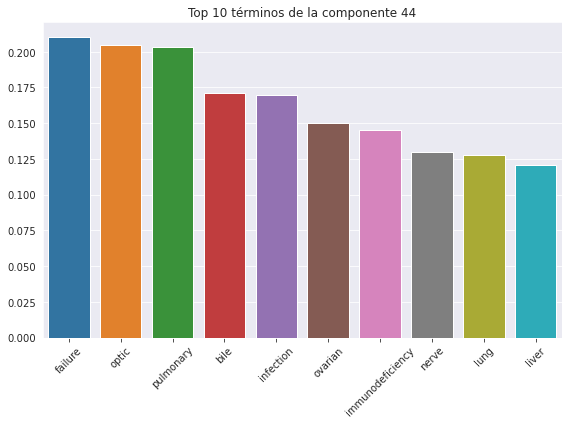

In [62]:
nodo = 2682
vector_lsa = lsa_data.toarray()[nodo]
top_10_components_idx = np.argsort(-vector_lsa)[0:10]
top_10_components_score = vector_lsa[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:5]:
    plot_component_vocab(component)

In [60]:
graph_node_data[graph_node_data[algoritmo] == cluster]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
3815,18183_5970,staphylococcal pneumonia,bert_group,primekg,574.0,14.0,0.0,0.0,6.0
20524,C0032308,Staphylococcal Pneumonia,disease,disgenet,574.0,14.0,0.0,0.0,1.0
20869,C0038159,Staphylococcal Food Poisoning,disease,disgenet,574.0,14.0,0.0,0.0,1.0
20870,C0038160,Staphylococcal Infections,disease,disgenet,574.0,14.0,5.0,0.0,4.0
20871,C0038165,Staphylococcal Scalded Skin Syndrome,disease,disgenet,574.0,14.0,0.0,0.0,2.0
25881,C0857862,Staphylococcus Aureus Pneumonia,disease,disgenet,574.0,14.0,0.0,0.0,2.0
26393,C1318973,Staphylococcus aureus infection,disease,disgenet,574.0,14.0,5.0,0.0,4.0
